In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# from math import comb
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from pathlib import Path
dir_data = Path('./data')

C:\Users\Jonatan\AppData\Local\Temp\ipykernel_6616\1413361061.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from xgboost import XGBClassifier 
from sklearn.model_selection import cross_val_score
def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy",
    )
    score = score.mean()
#     score = np.sqrt(score)
    return score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def do_pca(X, n):
    '''
    Given a df or array X and a number of components n, gives the model and the
    transformed features as output (Watchout: Inside we standardize)
    '''
    # Before PCA is a must to standardize features
    sc = StandardScaler()
    X = sc.fit_transform(X)
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)
    return pca, X_pca


def pca_importance(pca):
    '''
    Given a PCA model, percentage of importance for each component is showed.
    '''
    components = pca.components_  # Axis of maximum variation
    n = len(components)
    x = np.arange(n)
    values = pca.explained_variance_ratio_ * 100
    acvalues = np.cumsum(values)

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.bar(x, values)
    ax.plot(x, acvalues)
    for i in x:
        ax.annotate("{}%".format(round(values[i], 2)), (i-.1, values[i]),
                    fontsize=15)
        ax.annotate("{}%".format(round(acvalues[i], 2)), (i-.1, acvalues[i]),
                    fontsize=15)
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Variability (%)")

# Introducción

En esta práctica vamos a cubrir los siguientes puntos:

   * Caso de Uso
   * Reducción de la Dimensionalidad
        - Aplicación de PCA para reducción del número de variables
        - Interpretación de Resultados de PCA
   * Algoritmos de Clustering
        - Algoritmos Jerárquicos e interpretación de resultados
        - K-Means e interpretación de resultados
   * Métricas
        - Cálculo de índices externos
        - Uso de métricas para determinar parámetros de modelo

# Caso de Uso

Para el desarrollo de esta práctica se utilizará el dataset disponible en `mobile_data.csv`. Este es un conjunto de datos tomado de la popular plataforma de ciencia de datos [Kaggle](https://www.kaggle.com/). Accediendo al siguiente [enlace](https://www.kaggle.com/iabhishekofficial/mobile-price-classification) se tiene la fuente.

La descripción que encontramos es la siguiente:

'''
Bob ha creado su propia empresa de móviles. Quiere plantar cara a grandes empresas como Apple, Samsung, etc.

No sabe cómo calcular el precio de los móviles que fabrica su empresa. En este mercado tan competitivo de la telefonía móvil no puede simplemente suponer cosas. Para resolver este problema, recopila datos de ventas de teléfonos móviles de varias empresas.

Bob quiere averiguar la relación entre las características de un teléfono móvil (p. ej., RAM, memoria interna, etc.) y su precio de venta. Pero no es muy bueno en el aprendizaje automático. Así que necesita tu ayuda para resolver este problema.

En este problema no tienes que predecir el precio real, sino un rango de precios que indique lo alto que es el precio
'''

Las variables recopiladas por Bob son las siguientes:

* **battery_power**: Energía total que la batería puede almacenar en una carga medido en mAh.

* **blue**: Tiene Bluetooth o no.

* **clock_speed**: Velocidad a la que el microprocesador ejecuta las instrucciones.

* **dual_sim**: Tiene Dual SIM o no.

* **fc**: Mega pixels de la cámara frontal.

* **four_g**: Tiene 4G o no.

* **int_memory**: Memoria interna en Gigabytes.

* **m_dep**: Profundidad del móvil en cm.

* **mobile_wt**: Peso del móvil en gramos.

* **n_cores**: Número de núcleos del procesador.

* **pc**: Mega pixels de la cámara principal.

* **px_height**: Número de pixels de resolución en altura.

* **px_width**: Número de pixels de resolución en anchura.

* **ram**: Random Access Memory en Mega Bytes.

* **sc_h**: Altura del móvil en cm.

* **sc_w**: Anchura del móvil en cm.

* **talk_time**: Máximo tiempo de conversación con una caga de batería.

* **three_g**: Tiene 3G o no.

* **touch_screen**: Tiene pantalla táctil o no.

* **wifi**: Tiene wifi o no.

* **price_range**: Variable a predecir con valor of 0 (bajo coste), 1 (coste medio), 2 (coste alto) y 3 (coste muy alto).

In [3]:
cols = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep',
        'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time',
        'three_g', 'touch_screen', 'wifi', 'price_range']

dtypes = {'battery_power':float, 'blue':int, 'clock_speed':float, 'dual_sim':int, 'fc':float, 'four_g':int,
          'int_memory':float, 'm_dep':float, 'mobile_wt':float, 'n_cores':float, 'pc':float, 'px_height':float,
          'px_width':float, 'ram':float, 'sc_h':float, 'sc_w':float, 'talk_time':float, 'three_g':int,
          'touch_screen':int, 'wifi':int, 'price_range':int}

df = pd.read_csv(dir_data.joinpath('mobile_data.csv'),
                 usecols=cols,
                 dtype=dtypes)


In [4]:
df.head()

battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0          842.0     0          2.2         0   1.0       0         7.0   
1         1021.0     1          0.5         1   0.0       1        53.0   
2          563.0     1          0.5         1   2.0       1        41.0   
3          615.0     1          2.5         0   0.0       0        10.0   
4         1821.0     1          1.2         0  13.0       1        44.0   

   m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0   2.0       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0   6.0      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0   6.0     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0   9.0     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  14.0     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  price_range  
0       19.0        0             0     1            1  
1        7.0        1             1     0            2  
2        9.0        1             1     0            2  
3       11.0        1             0     0            2  
4       15.0        1             1     0            1

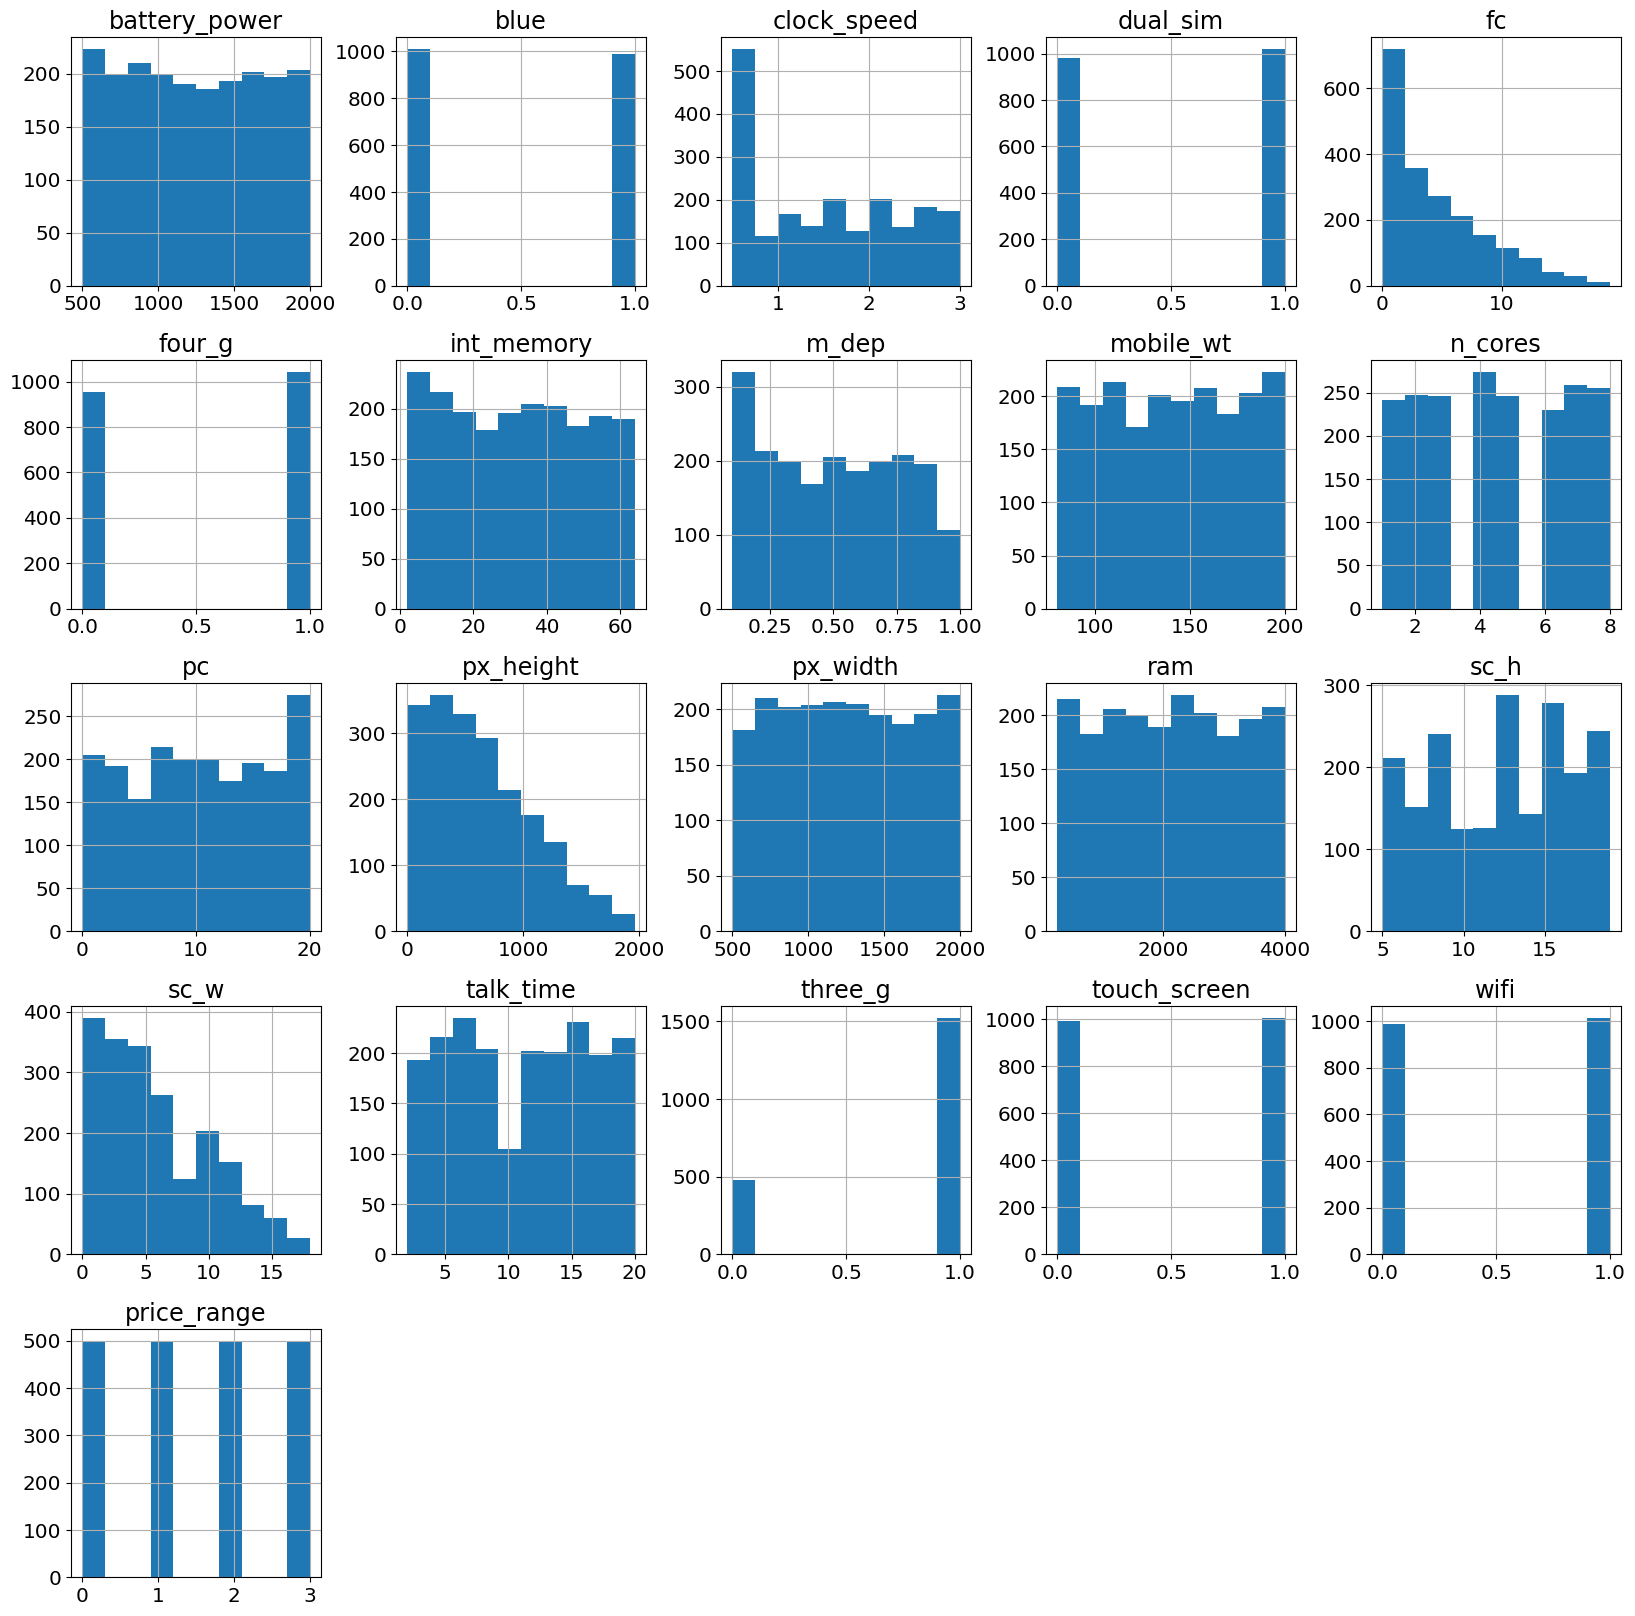

In [5]:
df.hist(figsize=(20, 20));

## Modelo Baseline

En las próximas secciones se harán distintas pruebas sobre la efectividad de la reducción de la dimensionalidad en las puntuaciones de un modelo de ML supervisado. Es por ello que establecemos un valor original sobre el cual se pretende obtener mejoras.

In [6]:
bs_score = score_dataset(df.drop(columns='price_range'), df['price_range'])
print("En el modelo BASELINE se obtiene un accuracy de {:.4f}".format(bs_score))

En el modelo BASELINE se obtiene un accuracy de 0.9075


# Reducción de la Dimensionalidad

La reducción de la dimensionalidad se puede hacer por
   1. Selección
       * % Valores Ausentes
       * Varianza
       * Intercorrelación
       * Relación con Target


   2. Transformación
       * Análisis de Componentes Principales
       * Ingeniería de Variables

## Selección

### Valores Ausentes

Este conjunto de datos está rigurosamente informado variable a variable y ha sido limpiado previamente por el autor, por lo que la falta de información en forma de valores missing no es un criterio válido para la selección de variables.

In [7]:
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

### Varianza

Es frecuente que encontremos variables cuya variación es tan baja, que realmente no supone de ayuda a los algoritmos a la hora de tomar decisiones, sirviendo únicamente para aumentar la dimensión del espacio e, incluso, introducir ruido estadístico o errores de redondeo.

Una buena manera de medir la variabilidad de una variable, es usando la coeficiente de variación $C_V$ dado por 

$$
C_V = \dfrac{\sigma}{|\overline{X}|}
$$

El coeficiente de variación se utiliza para comparar conjuntos de datos pertenecientes a poblaciones distintas. Si atendemos a su fórmula, vemos que este tiene en cuenta el valor de la media. Por lo tanto, el coeficiente de variación nos permite tener una medida de dispersión que elimine las posibles distorsiones de las medias de dos o más poblaciones.

In [8]:
df.describe()

battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.521500    32.046500     0.501750   140.249000     4.520500   
std       0.499662    18.145715     0.288416    35.399655     2.287837   
min       0.000000     2.000000     0.100000    80.000000     1.000000   
25%       0.000000    16.000000     0.200000   109.000000     3.000000   
50%       1.000000    32.000000     0.500000   141.000000     4.000000   
75%       1.000000    48.000000     0.800000   170.000000     7.000000   
max       1.000000    64.000000     1.000000   200.000000     8.000000   

                pc    px_height     px_width          ram         sc_h  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      9.916500   645.108000  1251.515500  2124.213000    12.306500   
std       6.064315   443.780811   432.199447  1084.732044     4.213245   
min       0.000000     0.000000   500.000000   256.000000     5.000000   
25%       5.000000   282.750000   874.750000  1207.500000     9.000000   
50%      10.000000   564.000000  1247.000000  2146.500000    12.000000   
75%      15.000000   947.250000  1633.000000  3064.500000    16.000000   
max      20.000000  1960.000000  1998.000000  3998.000000    19.000000   

              sc_w    talk_time      three_g  touch_screen         wifi  \
count  2000.000000  2000.000000  2000.000000   2000.000000  2000.000000   
mean      5.767000    11.011000     0.761500      0.503000     0.507000   
std       4.356398     5.463955     0.426273      0.500116     0.500076   
min       0.000000     2.000000     0.000000      0.000000     0.000000   
25%       2.000000     6.000000     1.000000      0.000000     0.000000   
50%       5.000000    11.000000     1.000000      1.000000     1.000000   
75%       9.000000    16.000000     1.000000      1.000000     1.000000   
max      18.000000    20.000000     1.000000      1.000000     1.000000   

       price_range  
count  2000.000000  
mean      1.500000  
std       1.118314  
min       0.000000  
25%       0.750000  
50%       1.500000  
75%       2.250000  
max       3.000000

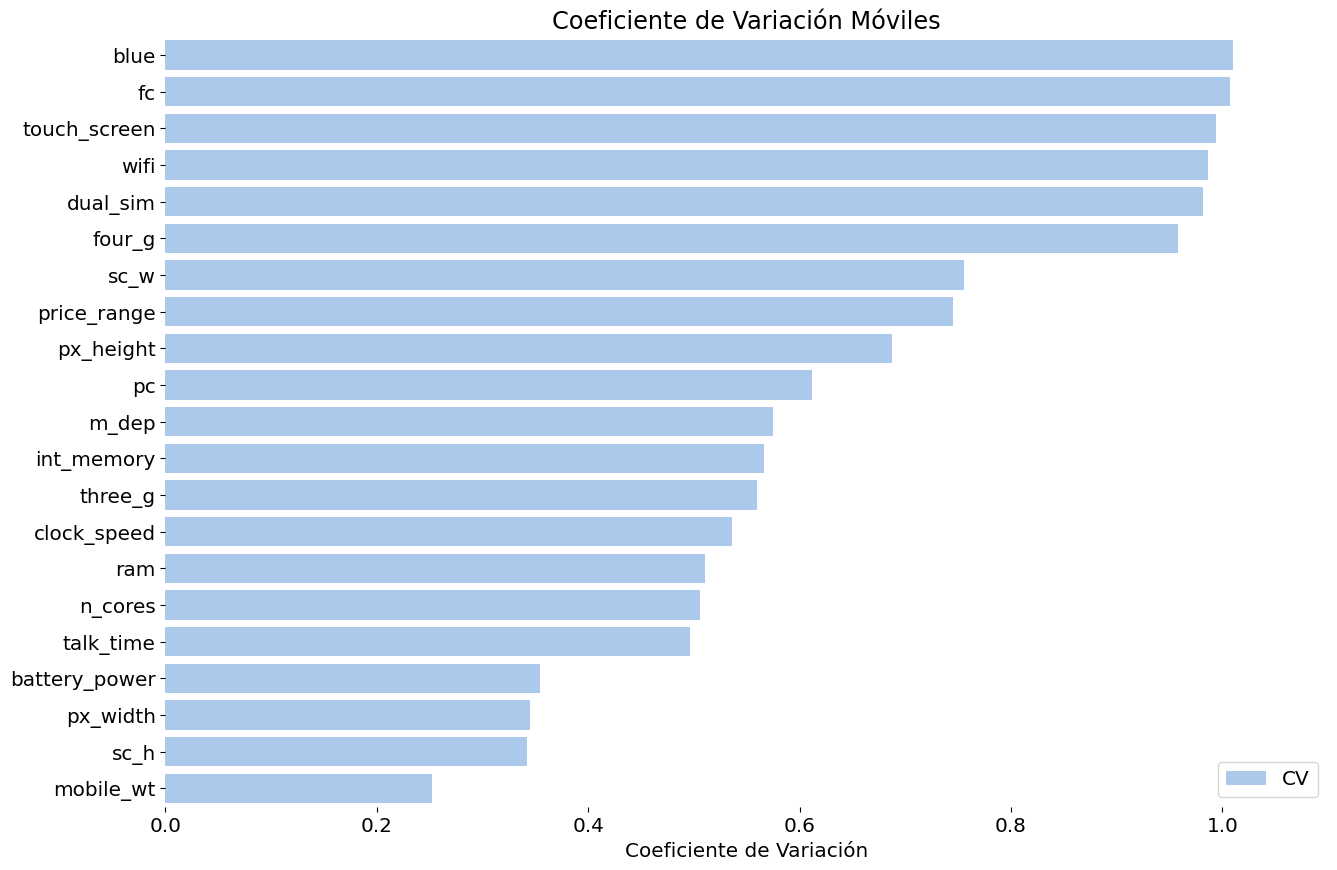

In [9]:
# Cálculo de los coeficientes de variación
df_cv = pd.DataFrame(df.std() / df.mean().abs(), columns=['CV'])
df_cv = df_cv.reset_index().sort_values(by='CV', ascending=False)

# Representación del coeficiente de variación Mobile Data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.set_color_codes("pastel")
sns.barplot(y='index', x="CV", data=df_cv,
            label="CV", color="b");

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1.1), ylabel="",
       xlabel="Coeficiente de Variación", title="Coeficiente de Variación Móviles")
sns.despine(left=True, bottom=True)

Aparentemente, los rangos de variablidad se encuentran en valores esperables. Aquellos con menos variabilidad parecen ser los asociados al tamaño del dispositivo. Aunque, a priori, no vamos a eliminar ninguna variable usando este criterio, sí es cierto que sugieren la introducción de variables derivadas de estas como podrían ser medidas de superficia, volumen o densidad de pixels del dispositivo.

### Correlaciones

La correlación entre variables indica que puede existir cierta dependencia lineal entre ambas. El signo de la pendiente de esta relación viene dado por el signo del coeficiente de correlación.

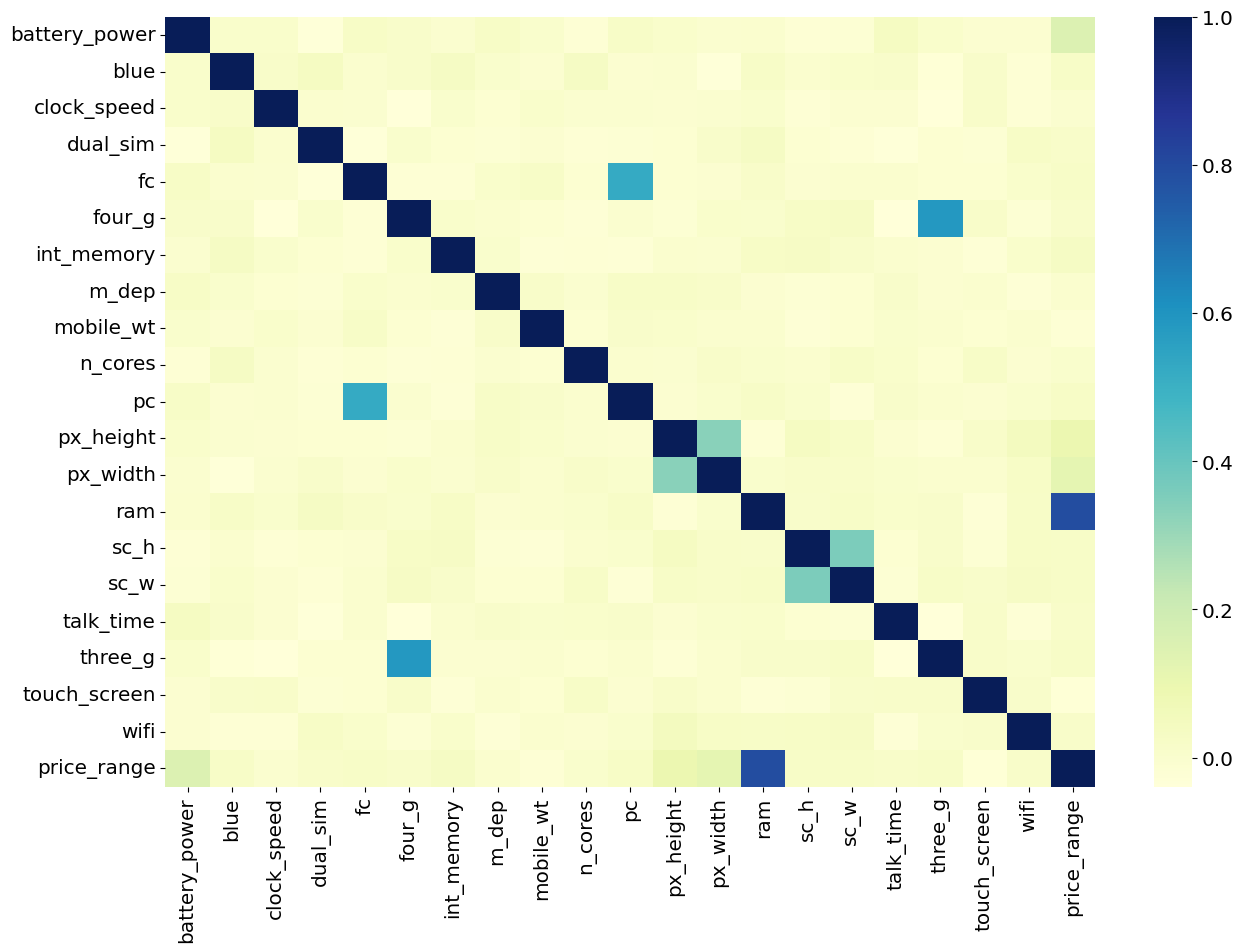

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(df.corr(method='kendall'), ax=ax, cmap="YlGnBu");

Correlaciones lineales encontradas entre predictores:
   * Megapixels de la cámara frontal (fc) y de la cámara principal(pc)
   * four_g y three_g
   * px_width y px_height

Correlaciones principales encontradas con el target:
   * ram
   * px_width
   * battery_power

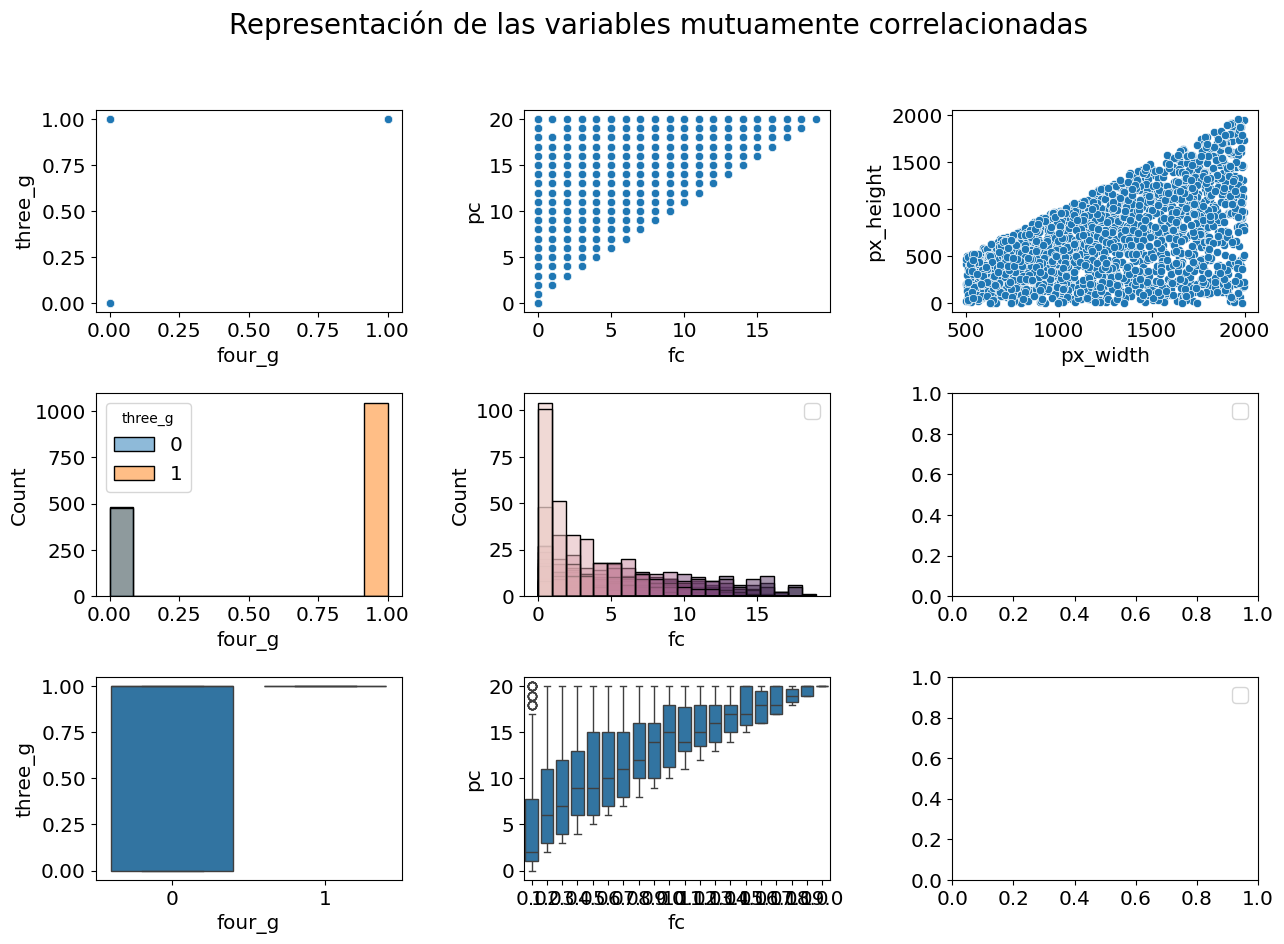

In [11]:
# Representación de las variables mutuamente relacionadas
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

# 4G vs 3G
sns.scatterplot(x='four_g', y='three_g', data=df, ax=ax[0][0])
sns.histplot(x='four_g', hue='three_g', data=df, ax=ax[1][0])
sns.boxplot(x='four_g', y='three_g', data=df, ax=ax[2][0])

# Frontal Camera vs Principal Camera
sns.scatterplot(x='fc', y='pc', data=df, ax=ax[0][1])
sns.histplot(x='fc', hue='pc', data=df, ax=ax[1][1])
sns.boxplot(x='fc', y='pc', data=df, ax=ax[2][1])
ax[1][1].legend('')

# Pixel height vs pixel width
sns.scatterplot(x='px_width', y='px_height', data=df, ax=ax[0][2])
# sns.histplot(x='px_width', hue='px_height', data=df, ax=ax[1][2])
# sns.boxplot(x='px_width', y='px_height', data=df, ax=ax[2][2])
ax[1][2].legend('')
ax[2][2].legend('')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.4, hspace=.4)

plt.suptitle("Representación de las variables mutuamente correlacionadas", fontsize=20)
plt.show()

Conclusiones: 
   * No existe el caso en el que el móvil no tiene 3G pero sí 4G, luego realmente hay 3 categorías: sin 3G ni 4G, con 3G y sin 4G, con 3G y con 4G.
   * La calidad de la cámara principal siempre es mayor que la de la cámara frontal.
   * La resolución en anchura del móvil siempre es menor que la de altura.

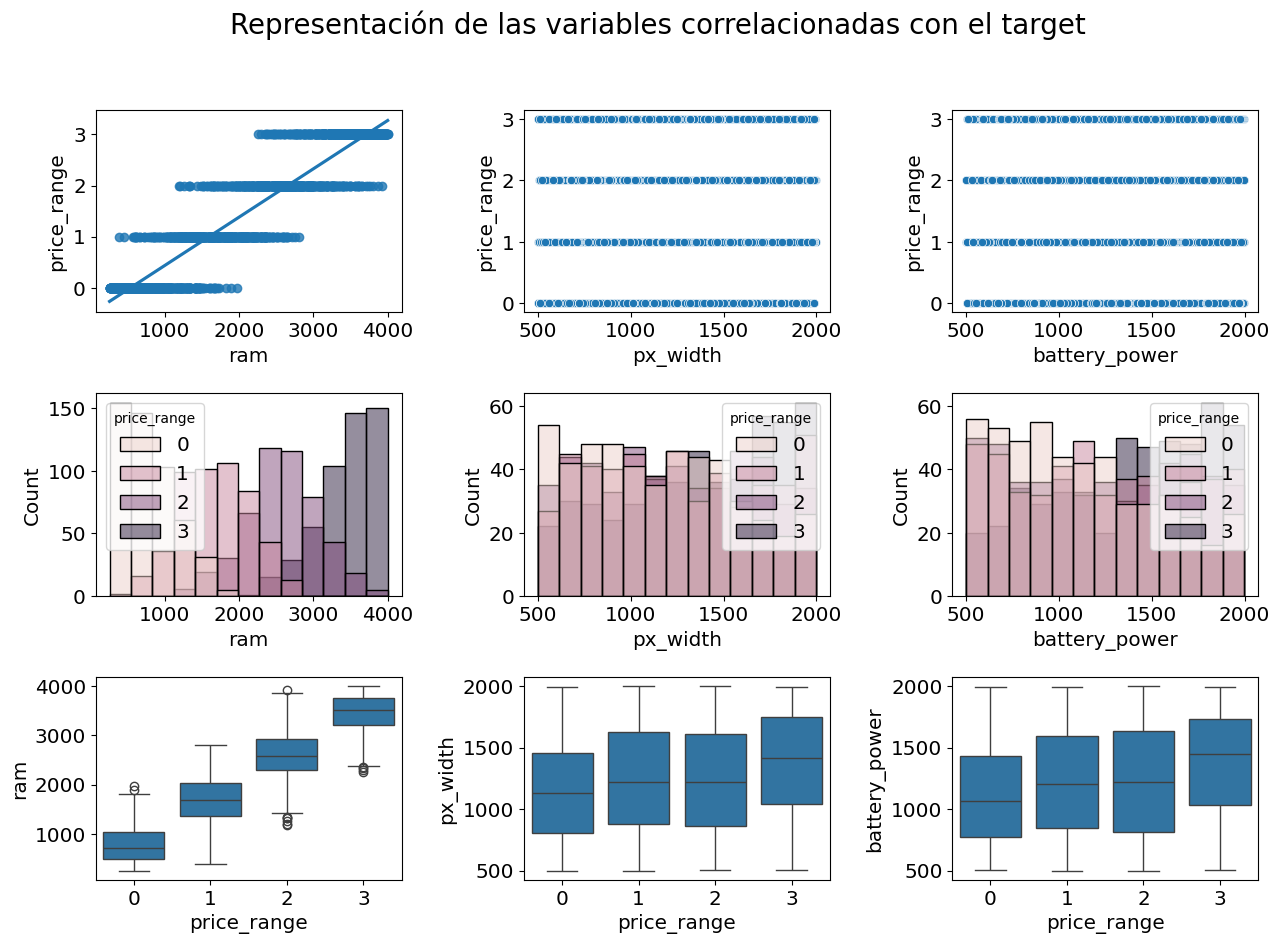

In [12]:
# Variables más correlacionadas con el target
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

# RAM
sns.regplot(x='ram', y='price_range', data=df, ax=ax[0][0])
sns.histplot(x='ram', hue='price_range', data=df, ax=ax[1][0])
sns.boxplot(x='price_range', y='ram', data=df, ax=ax[2][0])

# Pixel width
sns.scatterplot(x='px_width', y='price_range', data=df, ax=ax[0][1])
sns.histplot(x='px_width', hue='price_range', data=df, ax=ax[1][1])
sns.boxplot(x='price_range', y='px_width', data=df, ax=ax[2][1])

# Battery Power
sns.scatterplot(x='battery_power', y='price_range', data=df, ax=ax[0][2])
sns.histplot(x='battery_power', hue='price_range', data=df, ax=ax[1][2])
sns.boxplot(x='price_range', y='battery_power', data=df, ax=ax[2][2])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.4, hspace=.4)

plt.suptitle("Representación de las variables correlacionadas con el target", fontsize=20)
plt.show()

Conclusiones:
   * La relación entre la RAM y el precio parece ser bastante lineal con pendiente positiva.
   * Respecto a la resolución en anchura y la potencia de la batería, no se puede decir que haya una relación lineal aunque sí se observa cierta monotonía

## Análisis de Componentes Principales

Es importante tener en cuenta que el PCA realmente tiene sentido cuando se aplica a variables continuas en lugar de discretas. Por otra parte, de cara a perder la mínima cantidad de información posible, puede ser interesante agrupar las variables según las características del móvil que estén describiendo.

### PCA sobre todas las variables

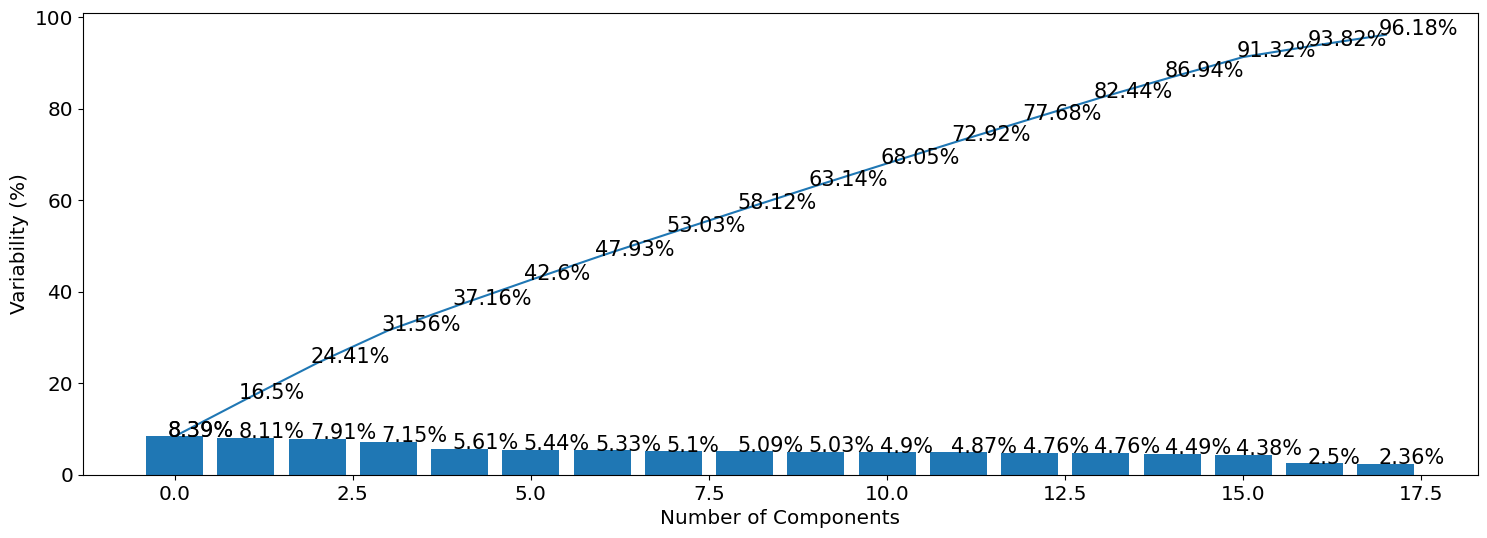

In [13]:
# Construcción de X e y
X = df.copy()
y = X['price_range']
X = df.drop(columns='price_range')

# Estrategia de escalado: Z-score
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Aplicación de PCA conservando el 95% de la varianza
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_sc)

# Representación de la varianza explicada por cada componente
pca_importance(pca)

In [14]:
# Pipeline: Serie de transformaciones-modelos consecutiva
pipe = make_pipeline(StandardScaler(), PCA(n_components=0.95), XGBClassifier())

# Score del modelo tras aplicar PCA a todo
dr_score = score_dataset(X, y, pipe)
dif_bs = dr_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(dr_score, dif_bs))

Reduciendo la dimensionalidad se tiene una precisión de 0.6960 (-0.2115 sobre el baseline)


### PCA sobre ciertas variables seleccionadas 

A priori, se pueden clasificar las variables en varios grupos:
   * Continuas y Discretas
   * De rendimiento, propiedades físicas del móvil y conectividad

#### Continuas VS. Discretas

In [15]:
# Definición de X e y de nuevo
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

# Variables float (continuas)
col_float = X.select_dtypes(include=float).columns
col_int = [x for x in X.columns if x not in col_float]
print("Número original de columnas: {}\n".format(len(col_float)))

# Pipeline que se va a aplicar
pipe_float = make_pipeline(StandardScaler(), PCA(n_components=.95))
pca_trans = ColumnTransformer(transformers=[('float', pipe_float, col_float),
                                            ('int', FunctionTransformer(), col_int)])

pipe = make_pipeline(pca_trans, XGBClassifier())

# Puntuación aplicando PCA sobre las variables continuas
drnum_score = score_dataset(X, y, pipe)
difnum_bs = drnum_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Número original de columnas: 14

Reduciendo la dimensionalidad se tiene una precisión de 0.7505 (-0.1570 sobre el baseline)


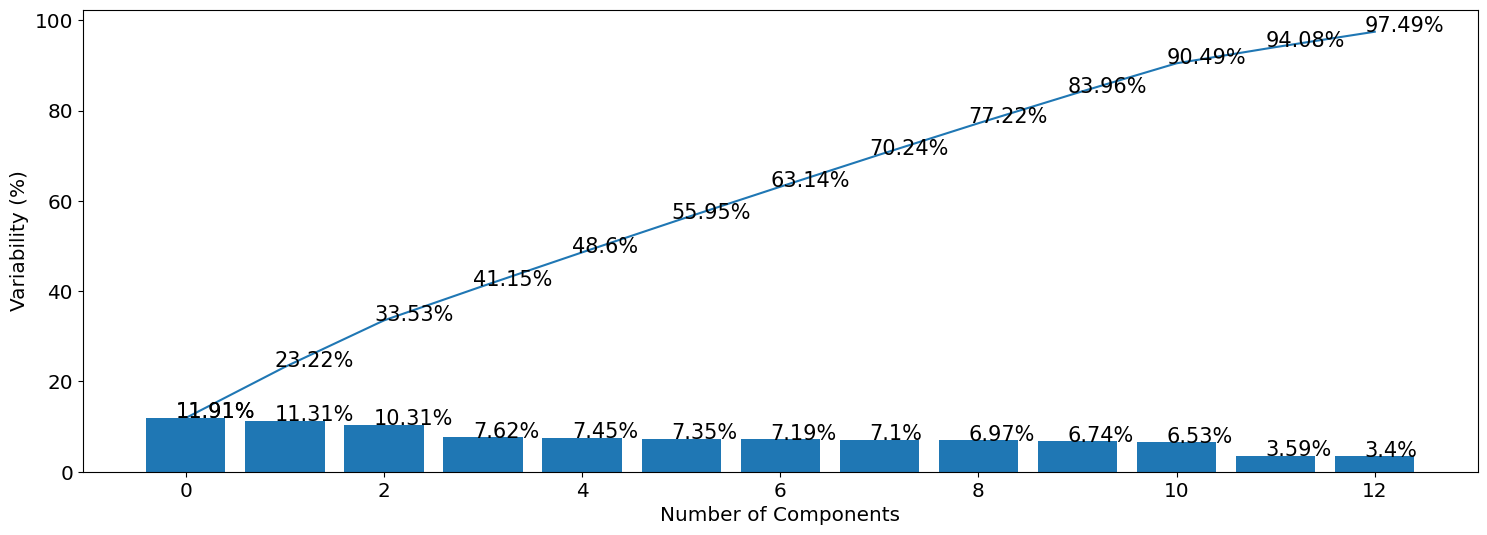

In [16]:
pca, _ = do_pca(X.select_dtypes(include=float), n=.95)
pca_importance(pca)

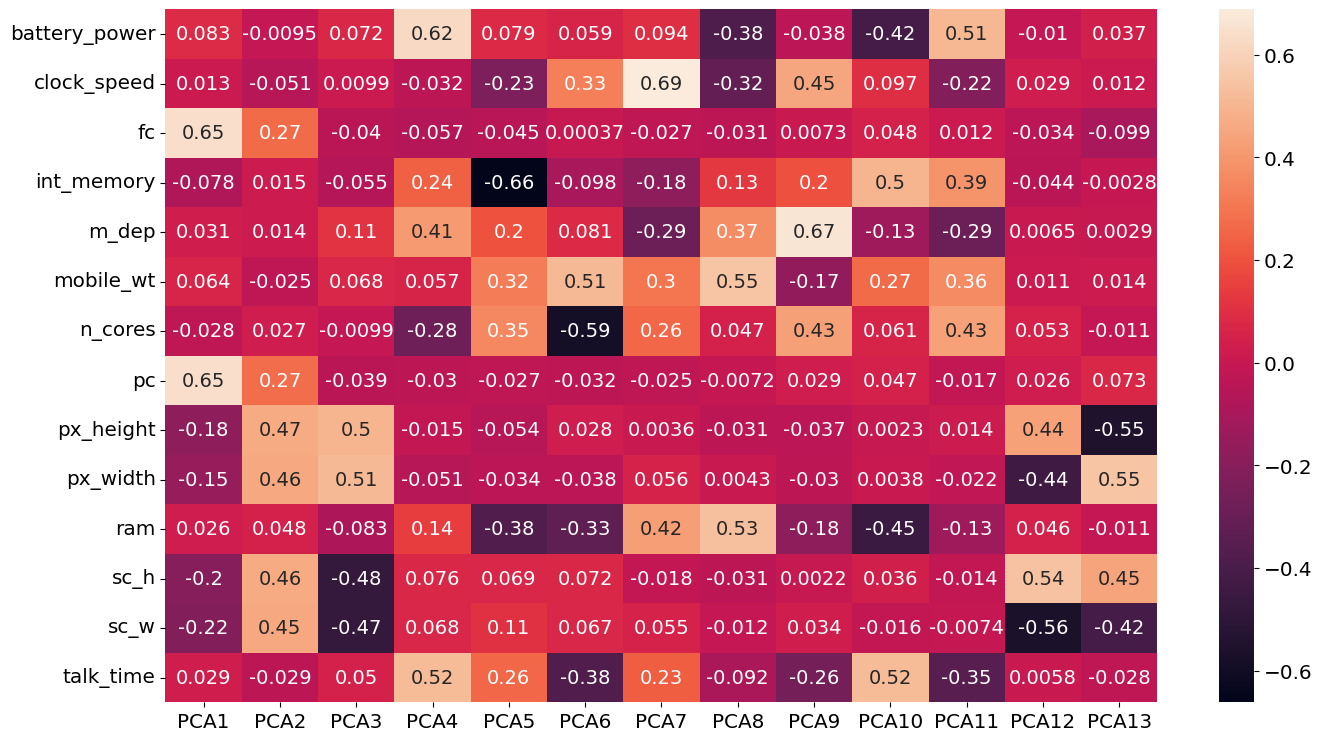

In [17]:
# Sacamos la matriz de pesos del PCA
component_names = ['PCA{}'.format(i) for i in range(1, pca.components_.shape[0] + 1)]
loadings = pd.DataFrame(
                            pca.components_.T,  # transpose the matrix of loadings
                            columns=component_names,  # so the columns are the principal components
                            index=X[col_float].columns,  # and the rows are the original features
                        )
fig, ax = plt.subplots(1,1, figsize=(16, 9))
sns.heatmap(loadings, annot=True, ax=ax, annot_kws={"size": 14});

**Conclusión**: Aunque claramente los resultados mejoran con respecto a realizar el PCA sobre todas las variables, seguimos teniendo un modelo peor que el modelo base porque las variables sobre las que se aplica, en general, no están correlacionadas.

#### Variables mutuamente correlacionadas

In [18]:
# Redefinimos X e y
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

# Seleccionamos las variables sobre las que queremos aplicar el PCA
col_corr = ['fc', 'pc', 'px_width', 'px_height']
col_id = [x for x in X.columns if x not in col_corr]
print("Número original de columnas: {}\n".format(len(col_corr)))

# Seleccionamos el número de variables con el que nos queremos quedar
pipe_float = make_pipeline(StandardScaler(), PCA(n_components=2))
pca_trans = ColumnTransformer(transformers=[('pca', pipe_float, col_corr),
                                            ('id', FunctionTransformer(), col_id)])
pipe = make_pipeline(pca_trans, XGBClassifier())

drnum_score = score_dataset(X, y, pipe)
difnum_bs = drnum_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Número original de columnas: 4

Reduciendo la dimensionalidad se tiene una precisión de 0.9155 (0.0080 sobre el baseline)


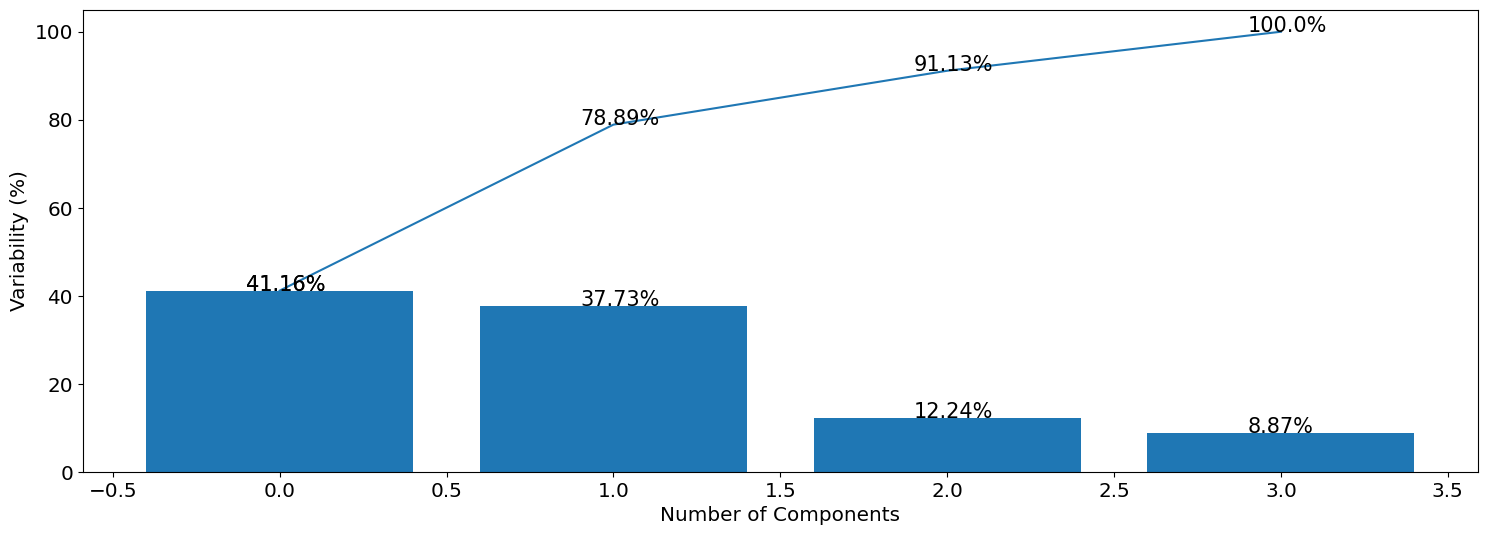

In [19]:
pca, _ = do_pca(X[col_corr], n=.95)
pca_importance(pca)

In [20]:
component_names = ['PCA{}'.format(i) for i in range(1, pca.components_.shape[0] + 1)]
loadings = pd.DataFrame(
                        pca.components_.T,  # transpose the matrix of loadings
                        columns=component_names,  # so the columns are the principal components
                        index=X[col_float].columns,  # and the rows are the original features
                    )
fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.heatmap(loadings, annot=True, ax=ax, annot_kws={"size": 14});

ValueError: Shape of passed values is (4, 4), indices imply (14, 4)

#### Otras Candidatas

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

col_float = ['clock_speed', 'int_memory',  'ram', 'n_cores']
print("Número original de columnas: {}\n".format(len(col_float)))
pipe_float = make_pipeline(StandardScaler(), PCA(n_components=.95))

pca_trans = ColumnTransformer(transformers=[('float', pipe_float, col_float),
                                            ('int', FunctionTransformer(), [x for x in X.columns if x not in col_float])])
pipe = make_pipeline(pca_trans, XGBClassifier())

drnum_score = score_dataset(X, y, pipe)
difnum_bs = drnum_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Número original de columnas: 4

Reduciendo la dimensionalidad se tiene una precisión de 0.8015 (-0.1115 sobre el baseline)


PCA1      PCA2      PCA3      PCA4
clock_speed  0.207645  0.272779  0.939397 -0.002997
int_memory   0.710436 -0.034925 -0.149085 -0.686902
ram          0.509930 -0.661865  0.081209  0.543426
n_cores     -0.438334 -0.697357  0.297846 -0.482540

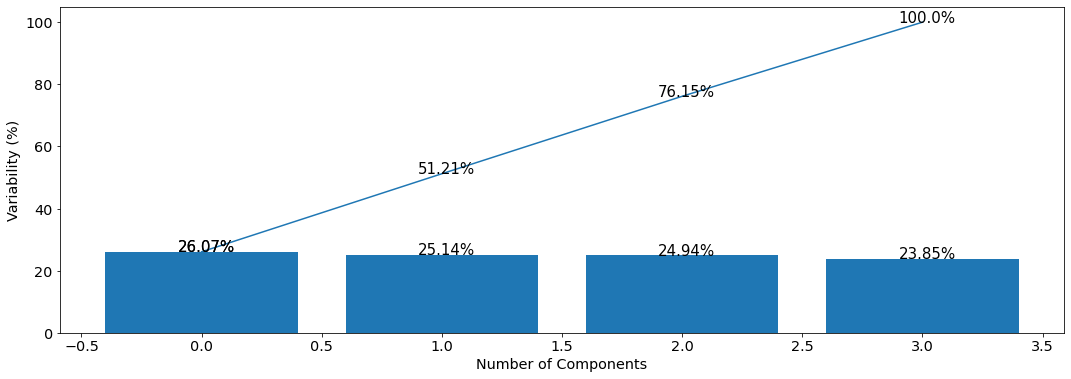

In [ ]:
pca, _ = do_pca(X[col_float], n=.95)
pca_importance(pca)

component_names = ['PCA{}'.format(i) for i in range(1, pca.components_.shape[0] + 1)]
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X[col_float].columns,  # and the rows are the original features
)
loadings


### PCA para Ingeniería de variables

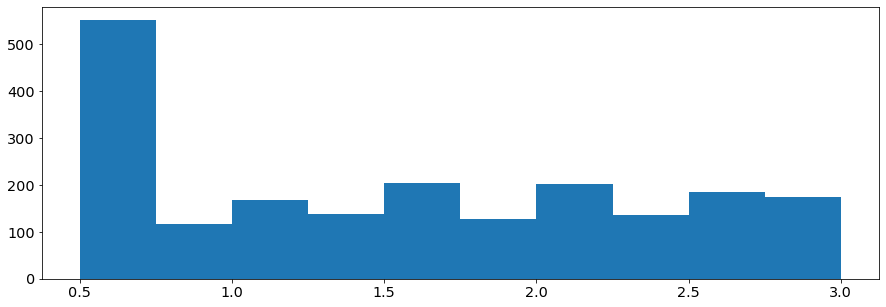

In [ ]:
plt.hist(df['clock_speed']);

In [ ]:
len(df.columns)

21

In [ ]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

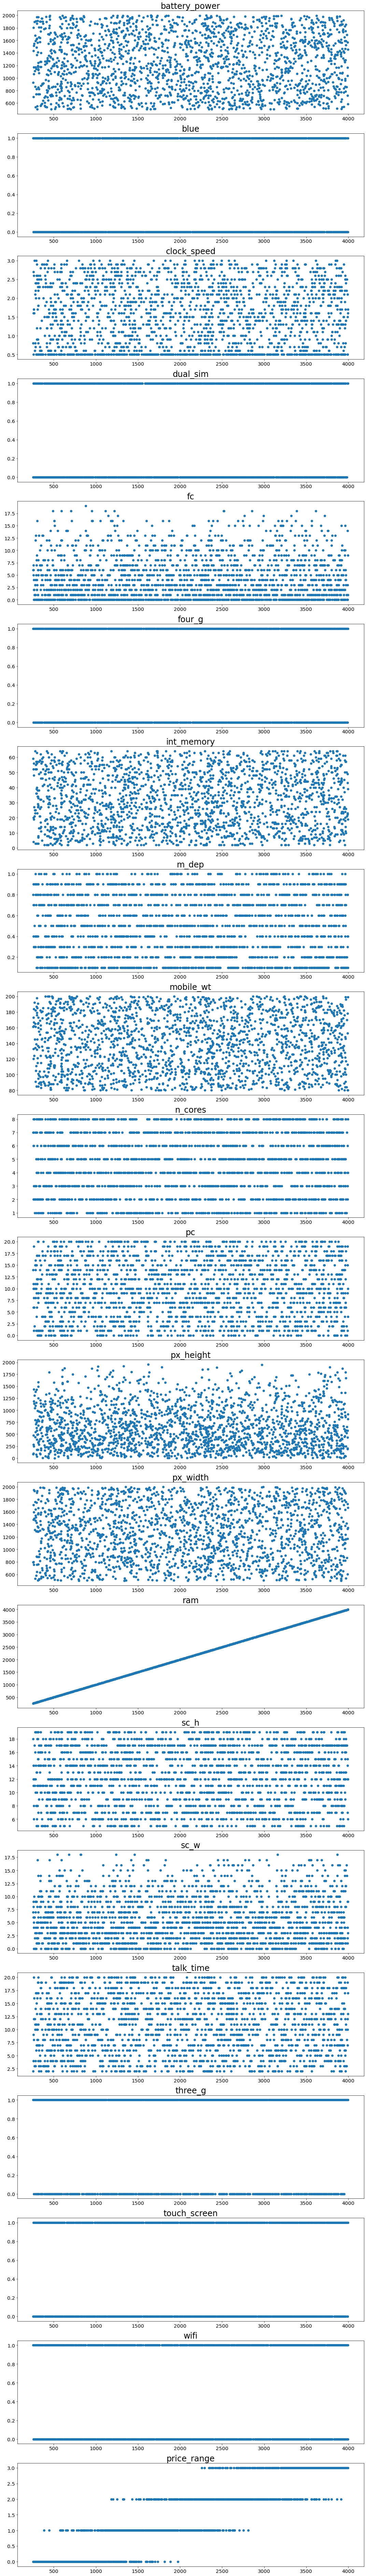

In [ ]:
# plt.subplots(len(df.columns), 1)
plt.figure(figsize=(15, 5 * len(df.columns)))
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i+1)
    plt.scatter(df['ram'], df[col])
    plt.title(col, fontsize=24)

plt.tight_layout()

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

X['camera_prod'] = (X['fc'] + X['pc']) ** 2
X['sc_w'] = np.where(X['sc_w'].values == 0, X['sc_h'] * (9/16), X['sc_w'].values)
X['px_surf_dens'] = X['px_width'] * X['px_height'] / (X['sc_w'] * X['sc_h'])
X['px_num'] = X['px_width'] * X['px_height']

X.drop(columns=['fc', 'pc'], inplace=True)

# X['conn'] = X['four_g'] + X['three_g'] + X['wifi'] + X['blue']
# X.drop(columns=['three_g', 'wifi'], inplace=True)

drnum_score = score_dataset(X, y)
difnum_bs = drnum_score - bs_score
print("Haciendo ingeniería de predictores basada en PCA se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Haciendo ingeniería de predictores basada en PCA se tiene una precisión de 0.9170 (0.0040 sobre el baseline)


# Clustering

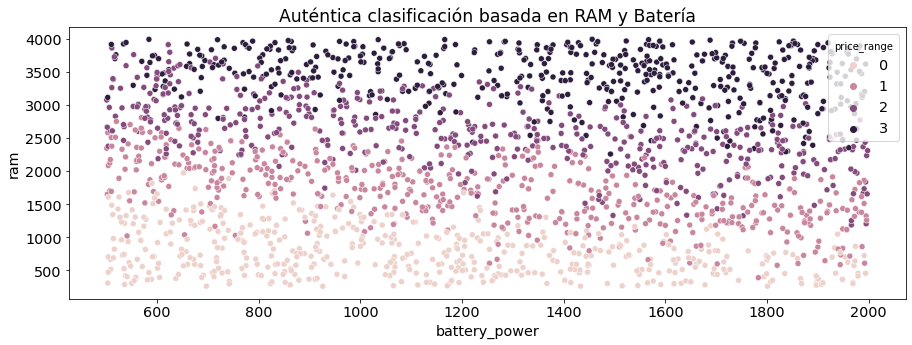

In [ ]:
ax2 = sns.scatterplot(x='battery_power', y='ram', hue='price_range', data=df)
ax2.set(title='Auténtica clasificación basada en RAM y Batería');
plt.show()

## Hierarchical Clustering

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

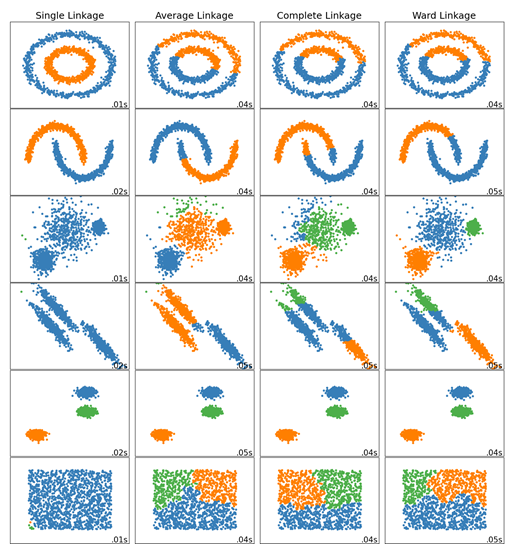

### Ward

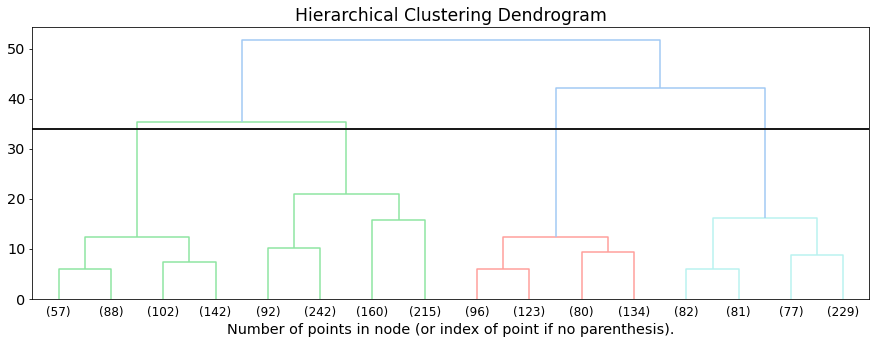

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_sc)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=34, color='k', linestyle='-', linewidth=2)
plt.show()

0    709
1    469
2    433
3    389
Name: cluster, dtype: int64


METRICS:

Adjusted Rand Index: 0.23
Silhouette Score: 0.36



battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0          842.0     0          2.2         0   1.0       0         7.0   
1         1021.0     1          0.5         1   0.0       1        53.0   
2          563.0     1          0.5         1   2.0       1        41.0   
3          615.0     1          2.5         0   0.0       0        10.0   
4         1821.0     1          1.2         0  13.0       1        44.0   

   m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0   2.0       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0   6.0      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0   6.0     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0   9.0     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  14.0     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  cluster  
0       19.0        0             0     1        0  
1        7.0        1             1     0        1  
2        9.0        1             1     0        1  
3       11.0        1             0     0        1  
4       15.0        1             1     0        3

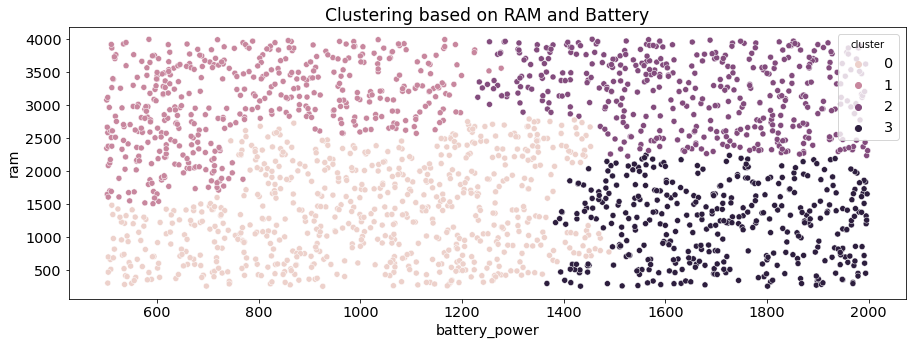

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_ward.fit(X_sc)

X['cluster'] = agg_ward.labels_

print(X.cluster.value_counts().sort_index())

ari = adjusted_rand_score(X['cluster'], y)
sil = silhouette_score(X_sc, labels=X['cluster'])
print('\n\nMETRICS:')
print('\nAdjusted Rand Index: {:.2f}'.format(ari))
print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='battery_power', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

X.head()

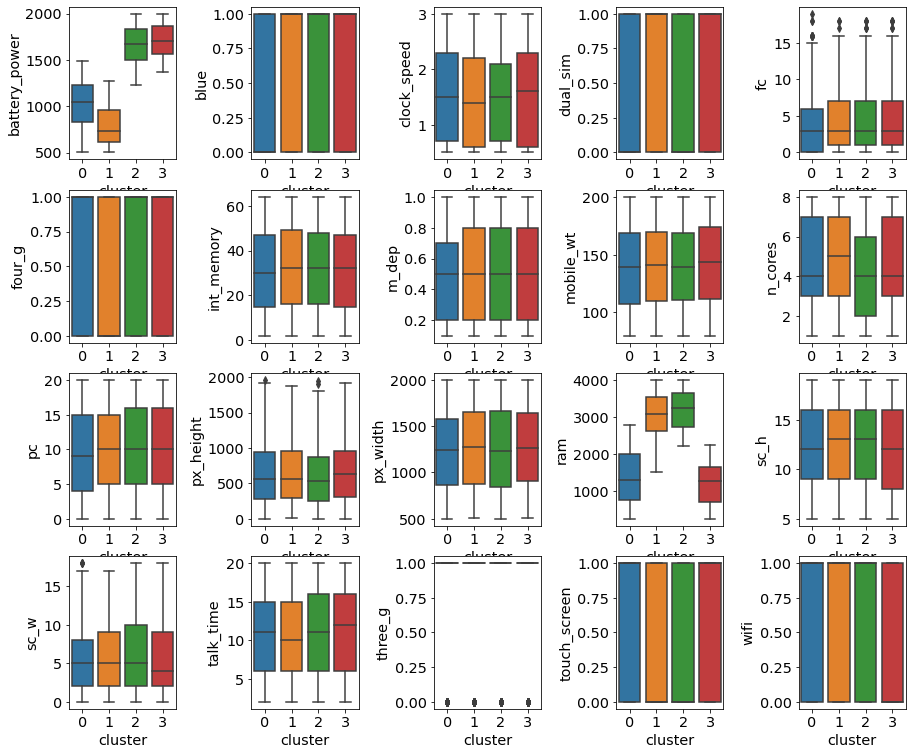

In [ ]:
rows = len(X.columns) // 4 - 1
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(15, 10));

for i in range(rows):
    for j in range(cols):
        sns.boxplot(x='cluster', y=X.columns[min(5*i + j, len(X.columns) - 1)], data=X, ax=ax[i][j])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=.7, hspace=None)

### Single Linkage

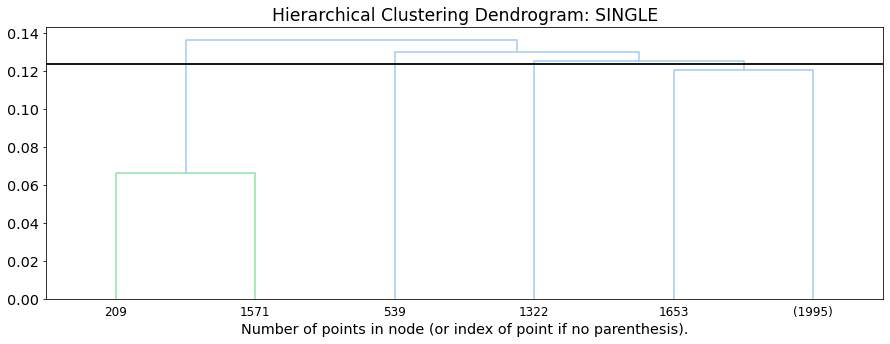

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(X_sc)

plt.title('Hierarchical Clustering Dendrogram: SINGLE')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=.124, color='k', linestyle='-', linewidth=2)
plt.show()

0    1996
1       2
2       1
3       1
Name: cluster, dtype: int64


METRICS:

Adjusted Rand Index: 0.00
Silhouette Score: -0.38



battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0          842.0     0          2.2         0   1.0       0         7.0   
1         1021.0     1          0.5         1   0.0       1        53.0   
2          563.0     1          0.5         1   2.0       1        41.0   
3          615.0     1          2.5         0   0.0       0        10.0   
4         1821.0     1          1.2         0  13.0       1        44.0   

   m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0   2.0       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0   6.0      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0   6.0     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0   9.0     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  14.0     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  cluster  
0       19.0        0             0     1        0  
1        7.0        1             1     0        0  
2        9.0        1             1     0        0  
3       11.0        1             0     0        0  
4       15.0        1             1     0        0

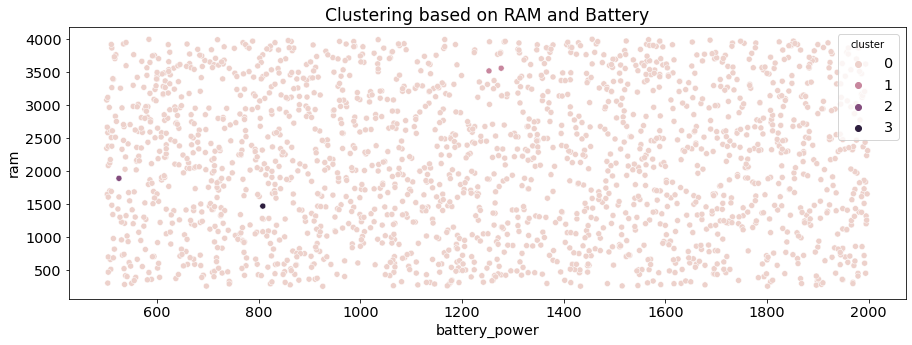

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)
# X = X.select_dtypes(include=np.float)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])


agg_sin = AgglomerativeClustering(n_clusters=4, linkage='single')
agg_sin.fit(X_sc)
X['cluster'] = agg_sin.labels_

print(X.cluster.value_counts().sort_index())

ari = adjusted_rand_score(X['cluster'], y)
sil = silhouette_score(X_sc, labels=X['cluster'])
print('\n\nMETRICS:')
print('\nAdjusted Rand Index: {:.2f}'.format(ari))
print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='battery_power', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

X.head()

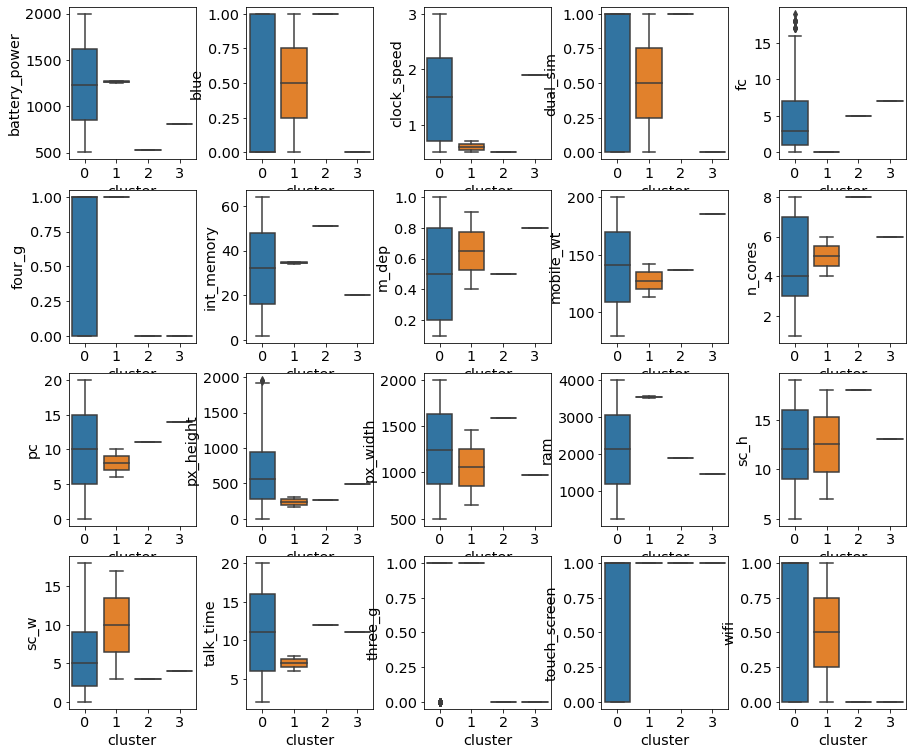

In [ ]:
rows = len(X.columns) // 4 -1
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(15, 10));

for i in range(rows):
    for j in range(cols):
        sns.boxplot(x='cluster', y=X.columns[min(5*i + j, len(X.columns)-1)], data=X, ax=ax[i][j])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=.4, hspace=None)

### Complete Linkage

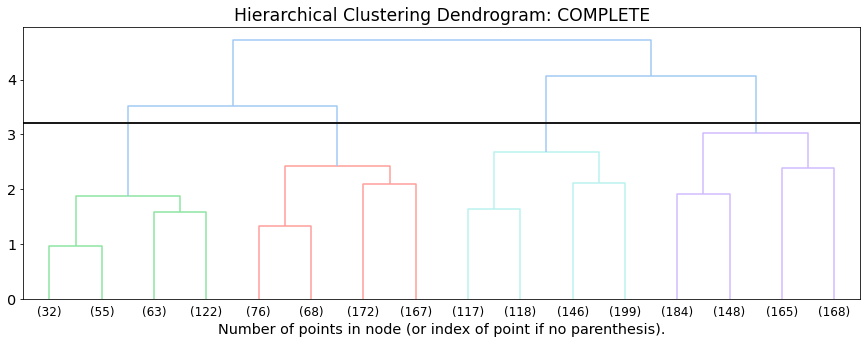

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(X_sc)

plt.title('Hierarchical Clustering Dendrogram: COMPLETE')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=3.2, color='k', linestyle='-', linewidth=2)
plt.show()

0    665
1    483
2    580
3    272
Name: cluster, dtype: int64


METRICS:

Adjusted Rand Index: 0.21
Silhouette Score: 0.31



battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0          842.0     0          2.2         0   1.0       0         7.0   
1         1021.0     1          0.5         1   0.0       1        53.0   
2          563.0     1          0.5         1   2.0       1        41.0   
3          615.0     1          2.5         0   0.0       0        10.0   
4         1821.0     1          1.2         0  13.0       1        44.0   

   m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0   2.0       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0   6.0      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0   6.0     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0   9.0     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  14.0     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  cluster  
0       19.0        0             0     1        2  
1        7.0        1             1     0        3  
2        9.0        1             1     0        2  
3       11.0        1             0     0        2  
4       15.0        1             1     0        0

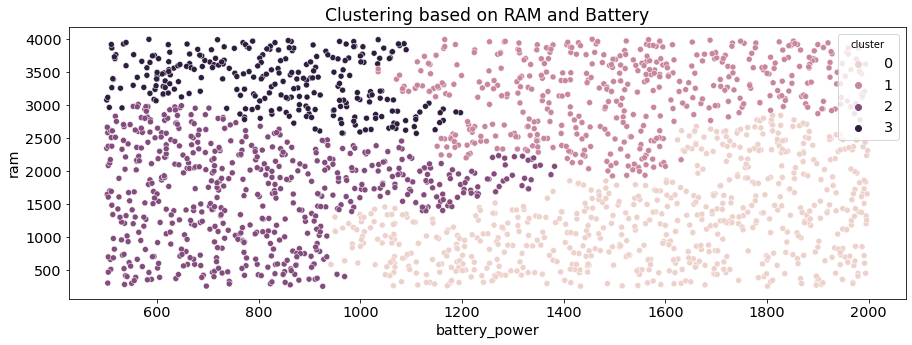

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)
# X = X.select_dtypes(include=np.float)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])


agg_comp = AgglomerativeClustering(n_clusters=4, linkage='complete')
agg_comp.fit(X_sc)
X['cluster'] = agg_comp.labels_

print(X.cluster.value_counts().sort_index())

ari = adjusted_rand_score(X['cluster'], y)
sil = silhouette_score(X_sc, labels=X['cluster'])
print('\n\nMETRICS:')
print('\nAdjusted Rand Index: {:.2f}'.format(ari))
print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='battery_power', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

X.head()

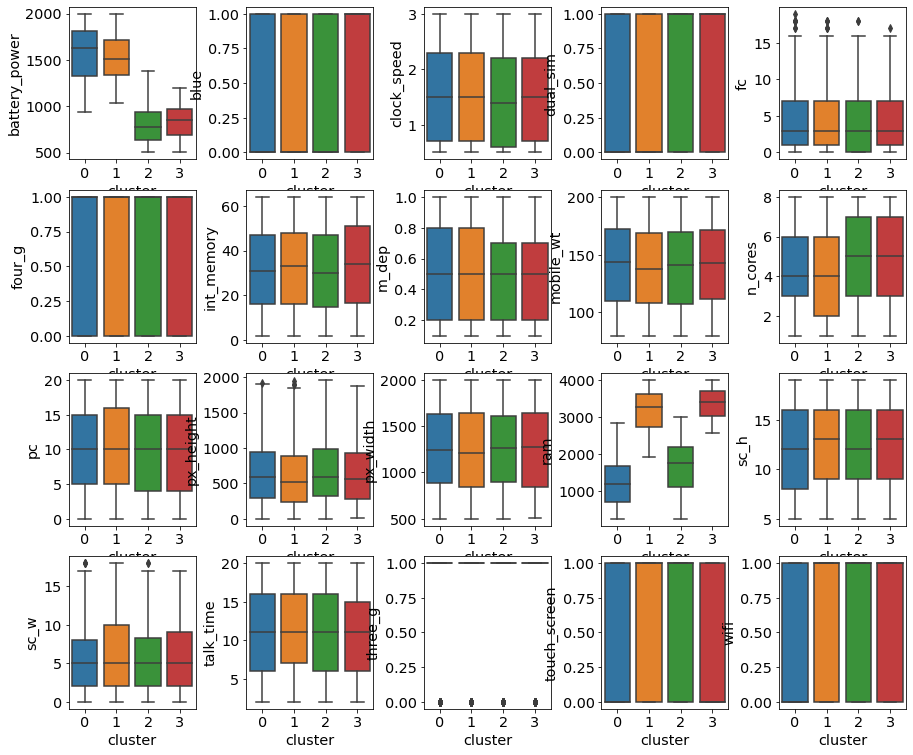

In [ ]:
rows = len(X.columns) // 4 -1
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(15, 10));

for i in range(rows):
    for j in range(cols):
        sns.boxplot(x='cluster', y=X.columns[min(5*i + j, len(X.columns)-1)], data=X, ax=ax[i][j])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=.4, hspace=None)

### Average Linkage

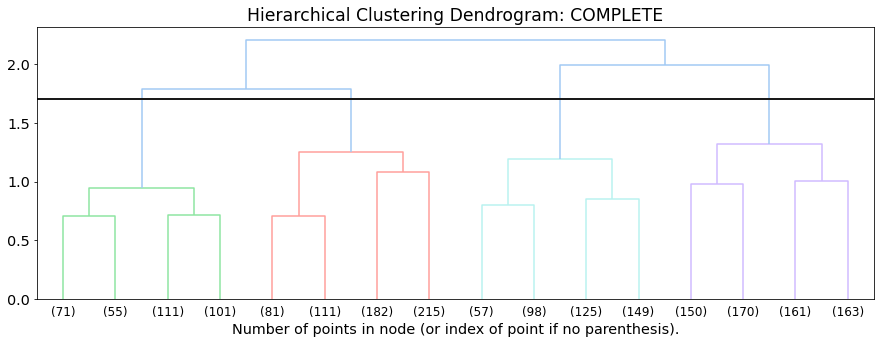

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(X_sc)

plt.title('Hierarchical Clustering Dendrogram: COMPLETE')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=1.7, color='k', linestyle='-', linewidth=2)
plt.show()

0    644
1    589
2    429
3    338
Name: cluster, dtype: int64


METRICS:

Adjusted Rand Index: 0.25
Silhouette Score: 0.37



battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0          842.0     0          2.2         0   1.0       0         7.0   
1         1021.0     1          0.5         1   0.0       1        53.0   
2          563.0     1          0.5         1   2.0       1        41.0   
3          615.0     1          2.5         0   0.0       0        10.0   
4         1821.0     1          1.2         0  13.0       1        44.0   

   m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0   2.0       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0   6.0      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0   6.0     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0   9.0     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  14.0     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  cluster  
0       19.0        0             0     1        1  
1        7.0        1             1     0        1  
2        9.0        1             1     0        1  
3       11.0        1             0     0        3  
4       15.0        1             1     0        2

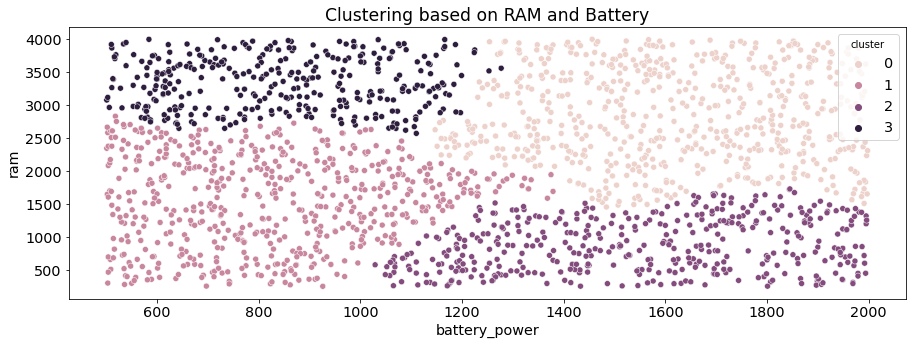

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)
# X = X.select_dtypes(include=np.float)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])


agg_avg = AgglomerativeClustering(n_clusters=4, linkage='average')
agg_avg.fit(X_sc)
X['cluster'] = agg_avg.labels_

print(X.cluster.value_counts().sort_index())

ari = adjusted_rand_score(X['cluster'], y)
sil = silhouette_score(X_sc, labels=X['cluster'])
print('\n\nMETRICS:')
print('\nAdjusted Rand Index: {:.2f}'.format(ari))
print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='battery_power', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

X.head()

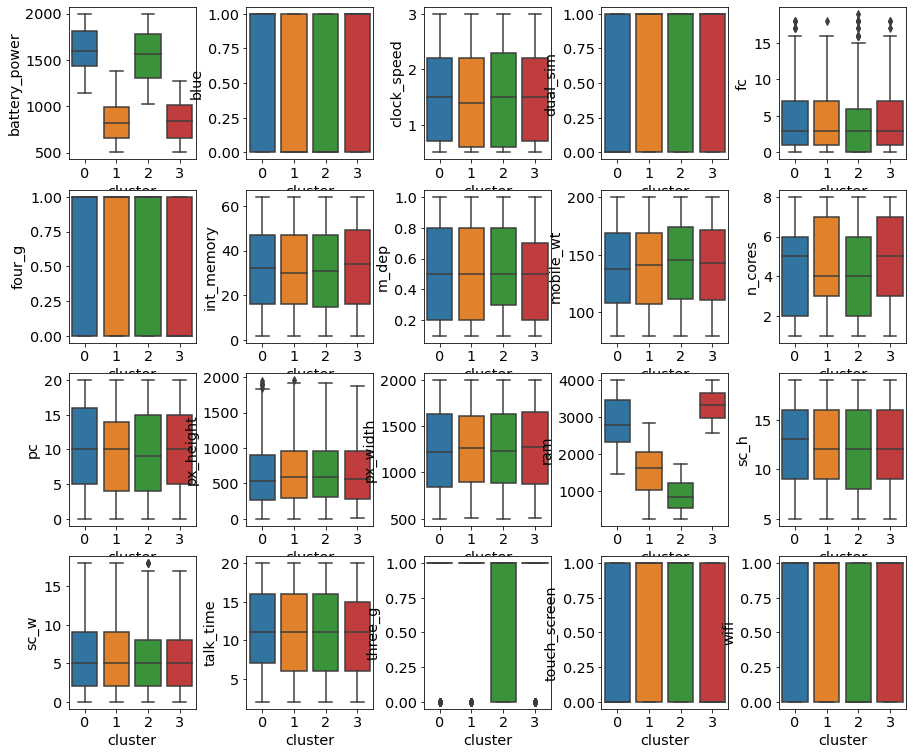

In [ ]:
rows = len(X.columns) // 4 -1
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(15, 10));

for i in range(rows):
    for j in range(cols):
        sns.boxplot(x='cluster', y=X.columns[min(5*i + j, len(X.columns)-1)], data=X, ax=ax[i][j])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.1, wspace=.4, hspace=None)

## Non Hierarchical

### K-Means

0    442
1    529
2    519
3    510
Name: cluster, dtype: int64


METRICS:

Adjusted Rand Index: 0.27
Silhouette Score: 0.41



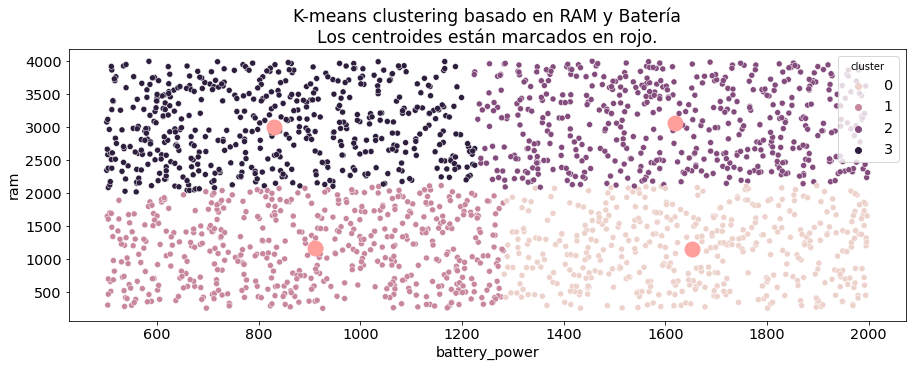

battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0          842.0     0          2.2         0   1.0       0         7.0   
1         1021.0     1          0.5         1   0.0       1        53.0   
2          563.0     1          0.5         1   2.0       1        41.0   
3          615.0     1          2.5         0   0.0       0        10.0   
4         1821.0     1          1.2         0  13.0       1        44.0   

   m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0   2.0       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0   6.0      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0   6.0     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0   9.0     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  14.0     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  cluster  
0       19.0        0             0     1        3  
1        7.0        1             1     0        3  
2        9.0        1             1     0        3  
3       11.0        1             0     0        3  
4       15.0        1             1     0        0

In [ ]:
from sklearn.cluster import KMeans
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

kmeans = KMeans(n_clusters=4, init="k-means++", n_init=4)
kmeans.fit(X_sc)

X['cluster'] = kmeans.labels_

print(X.cluster.value_counts().sort_index())

ari = adjusted_rand_score(X['cluster'], y)
sil = silhouette_score(X_sc, labels=X['cluster'])
print('\n\nMETRICS:')
print('\nAdjusted Rand Index: {:.2f}'.format(ari))
print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='battery_power', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

centroids = sc.inverse_transform(kmeans.cluster_centers_)

plt.scatter(centroids[:, 1], centroids[:, 0], marker="o", s=169, linewidths=3,
            color="r", zorder=10)
plt.title("K-means clustering basado en RAM y Batería\n"
          "Los centroides están marcados en rojo.")
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()

X.head()

#### Ingeniería de variables y K-Means

0    633
1    658
2     17
3    120
4    572
Name: cluster, dtype: int64


METRICS:

Adjusted Rand Index: 0.43
Silhouette Score: 0.45



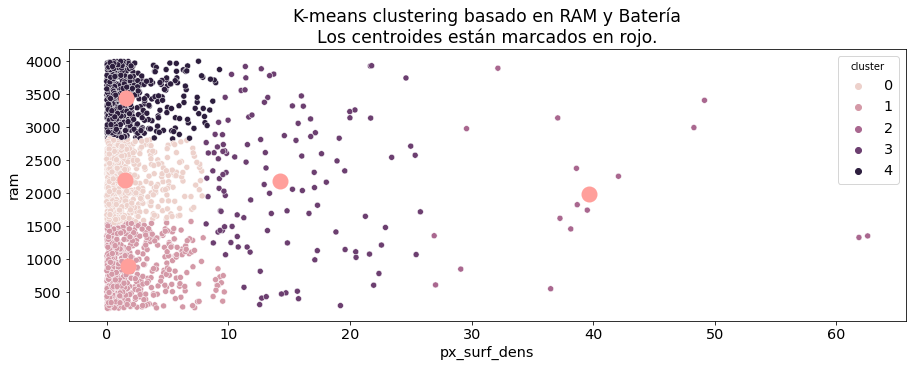

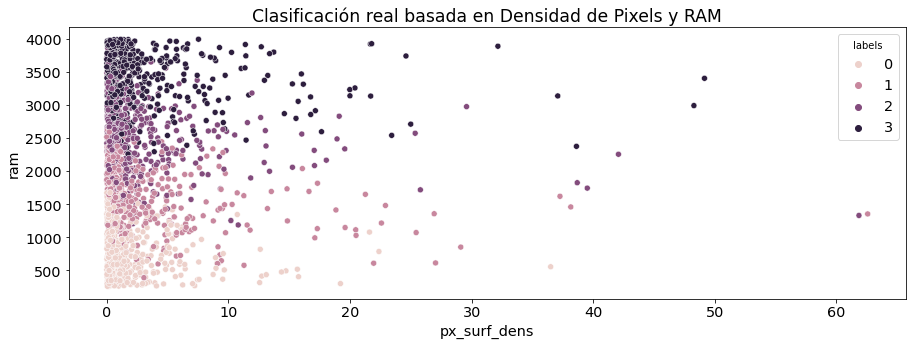

battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0          842.0     0          2.2         0   1.0       0         7.0   
1         1021.0     1          0.5         1   0.0       1        53.0   
2          563.0     1          0.5         1   2.0       1        41.0   
3          615.0     1          2.5         0   0.0       0        10.0   
4         1821.0     1          1.2         0  13.0       1        44.0   

   m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
0    0.6      188.0      2.0   2.0       20.0     756.0  2549.0   9.0   7.0   
1    0.7      136.0      3.0   6.0      905.0    1988.0  2631.0  17.0   3.0   
2    0.9      145.0      5.0   6.0     1263.0    1716.0  2603.0  11.0   2.0   
3    0.8      131.0      6.0   9.0     1216.0    1786.0  2769.0  16.0   8.0   
4    0.6      141.0      2.0  14.0     1208.0    1212.0  1411.0   8.0   2.0   

   talk_time  three_g  touch_screen  wifi  px_surf_dens  cluster  labels  
0       19.0        0             0     1      0.024000        0       1  
1        7.0        1             1     0      3.527725        0       2  
2        9.0        1             1     0      9.851400        3       2  
3       11.0        1             0     0      1.696700        0       2  
4       15.0        1             1     0      9.150600        3       1

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

# Definimos la nueva variable de densidad superficial
idx_q_nnul = X[(X['sc_w'] * X['sc_h'])!=0].index
idx_q_nul = X[(X['sc_w'] * X['sc_h'])==0].index
X.loc[idx_q_nul, ['sc_w']] = 0.5 * X.loc[idx_q_nul, ['sc_h']].values
X['px_surf_dens'] = X['px_width'].values * X['px_height'].values / (X['sc_w'].values * X['sc_h'].values) * 10**-4

sc = StandardScaler()
X_sc = X[['px_surf_dens', 'ram']].copy()
X_sc.loc[:, :] = sc.fit_transform(X_sc)
idx_ = X_sc.index
X_sc = X_sc.loc[idx_, :]

kmeans2 = KMeans(n_clusters=5, init="k-means++", n_init=4, random_state=0)

kmeans2.fit(X_sc)

X['cluster'] = kmeans2.labels_
# X_sc['cluster'] = kmeans2.labels_

print(X.cluster.value_counts().sort_index())

ari = adjusted_rand_score(X['cluster'], y[idx_])
sil = silhouette_score(X_sc, labels=X['cluster'])
print('\n\nMETRICS:')
print('\nAdjusted Rand Index: {:.2f}'.format(ari))
print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='px_surf_dens', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

# centroids = sc.inverse_transform(kmeans2.cluster_centers_)
centroids = sc.inverse_transform(kmeans2.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="o", s=169, linewidths=3,
            color="r", zorder=10)
plt.title("K-means clustering basado en RAM y Batería\n"
          "Los centroides están marcados en rojo.")
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()

X['labels'] =  y[idx_]

ax = sns.scatterplot(x='px_surf_dens', y='ram', hue='labels', data=X)
ax.set(title='Clasificación real basada en Densidad de Pixels y RAM');
plt.show()

X.head()

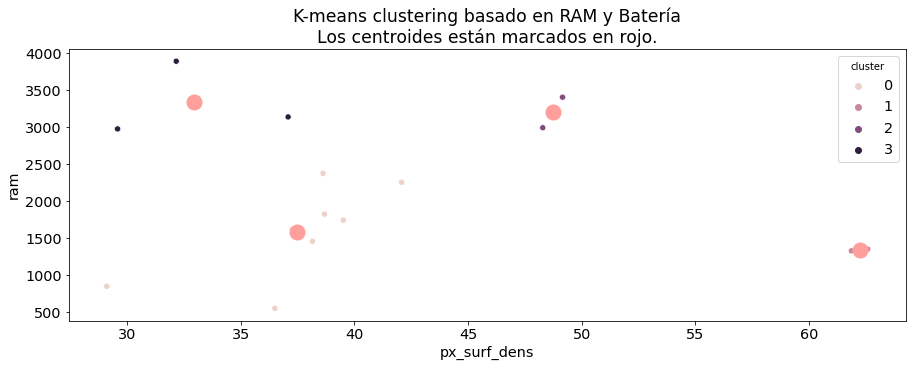

battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
372         1703.0     1          1.5         1  17.0       1        55.0   
429         1048.0     1          0.9         0  10.0       1        28.0   
516         1039.0     0          1.3         0   0.0       1        12.0   
541          793.0     0          1.2         1   1.0       1        38.0   
551         1900.0     1          2.0         1   1.0       0        41.0   

     m_dep  mobile_wt  n_cores    pc  px_height  px_width     ram  sc_h  sc_w  \
372    0.7      138.0      5.0  19.0     1411.0    1711.0  2993.0   5.0   1.0   
429    0.8      194.0      2.0  19.0      966.0    1975.0  1458.0   5.0   1.0   
516    0.8      200.0      8.0   0.0     1428.0    1827.0  1619.0   7.0   1.0   
541    0.6      176.0      4.0   7.0     1226.0    1815.0  3139.0   6.0   1.0   
551    0.5      190.0      8.0   6.0      912.0    1596.0   850.0   5.0   1.0   

     talk_time  three_g  touch_screen  wifi  px_surf_dens  cluster  
372       20.0        1             1     1      48.28442        2  
429       15.0        1             0     1      38.15700        0  
516       10.0        1             1     1      37.27080        0  
541       12.0        1             1     1      37.08650        3  
551        4.0        1             1     1      29.11104        0

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

# X['px_surf_dens'] = 0
idx_q_nnul = X[(X['sc_w'] * X['sc_h'])!=0].index
idx_q_nul = X[(X['sc_w'] * X['sc_h'])==0].index
X.loc[idx_q_nul, ['sc_w']] = 0.5 * X.loc[idx_q_nul, ['sc_h']].values
X['px_surf_dens'] = X['px_width'].values * X['px_height'].values / (X['sc_w'].values * X['sc_h'].values) * 10**-4
sc = StandardScaler()
X_sc = X[['px_surf_dens', 'ram']].copy()
X_sc.loc[:, :] = sc.fit_transform(X_sc)
idx_ = X_sc[X_sc['px_surf_dens'] >= 5].index
X_sc = X_sc.loc[idx_, :]
# X_sc[]
# X_sc = X[['px_surf_dens', 'ram']]

kmeans3 = KMeans(n_clusters=4, init="k-means++", n_init=100, max_iter=30000)

kmeans3.fit(X_sc)

X = X.loc[idx_, :]
X['cluster'] = kmeans3.labels_

# print(X_sc.cluster.value_counts().sort_index())

# ari = adjusted_rand_score(X_sc['cluster'], y[idx_])
# sil = silhouette_score(X_sc, labels=X_sc['cluster'])
# print('\n\nMETRICS:')
# print('\nAdjusted Rand Index: {:.2f}'.format(ari))
# print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='px_surf_dens', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

centroids = sc.inverse_transform(kmeans3.cluster_centers_)
# centroids = kmeans3.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="o", s=169, linewidths=3,
            color="r", zorder=10)
plt.title("K-means clustering basado en RAM y Batería\n"
          "Los centroides están marcados en rojo.")
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()

X.head()

## Métricas

Evaluar el rendimiento de un algoritmo de agrupación no es tan trivial como contar el número de errores o la precisiónde un algoritmo de clasificación supervisada. En particular, cualquier métrica de evaluación no debería tener en cuenta los valores absolutos de las etiquetas de los clústeres, sino más bien si esta agrupación define separaciones de los datos similares a algún conjunto de clases de la verdad básica o satisface alguna suposición como que los miembros que pertenecen a la misma clase son más similares que los miembros de clases diferentes según alguna métrica de similitud.

En función de si usan etiquetas proporcionadas o no se encuentran las métricas:
* **Externas**: Adjusted Rand Index, Adjusted Mutual Information, Homogeneidad, Completitud y V-measure.
* **Internas**: Silhouette Score, Carlinski-Harabasz Index, Davies-Bouldin Index. 

### Externas

#### Adjusted Rand Index

Dado el conocimiento de las asignaciones de clase de la verdad básica labels_true y las asignaciones de nuestro algoritmo de clustering de las mismas muestras labels_pred, el índice de Rand (ajustado o no ajustado) es una función que mide la similitud de las dos asignaciones, ignorando las permutaciones.

Etiquetas Reales -> U, Predicciones -> V
* a: pares con las mismas etiquetas en U y V
* b: pares que están en la misma clase en U y distinto cluster en V
* c: pares en el mismo cluster en V pero distintas clases en U
* d: pares en en diferentes clusters y clases (U and V)
$$
Rand Index = \dfrac{𝑎+𝑑}{𝑎+𝑏+𝑐+𝑑}
$$

PROBLEMA: Si usamos un modelo Random, el valor puede variar. Idealmente, debería valer 0 en este caso.

$$
Adjusted Rand Index = \dfrac{𝑅𝐼 −𝐸[𝑅𝐼]}{\max⁡(𝑅𝐼) − 𝐸[𝑅𝐼]}
$$

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

# Definimos la nueva variable de densidad superficial
idx_q_nnul = X[(X['sc_w'] * X['sc_h'])!=0].index
idx_q_nul = X[(X['sc_w'] * X['sc_h'])==0].index
X.loc[idx_q_nul, ['sc_w']] = 0.5 * X.loc[idx_q_nul, ['sc_h']].values
X['px_surf_dens'] = X['px_width'].values * X['px_height'].values / (X['sc_w'].values * X['sc_h'].values) * 10**-4

sc = StandardScaler()
X_sc = X[['px_surf_dens', 'ram']].copy()
X_sc.loc[:, :] = sc.fit_transform(X_sc)
idx_ = X_sc.index
X_sc = X_sc.loc[idx_, :]

In [ ]:

labels_true = kmeans2.labels_
labels_pred = y.values

# a = 
cont = metrics.cluster.contingency_matrix(labels_pred, labels_true)
df_cont = pd.DataFrame(cont, index=list(set(labels_pred)), columns=list(set(labels_true)))

a = comb(10,3)
# b = 
print("Matriz de contingencia:\n\n\tFilas: Clases predichas\n\tColumnas: Etiquetas reales")
df_cont

Matriz de contingencia:

	Filas: Clases predichas
	Columnas: Etiquetas reales


0    1  2   3    4
0   14  473  1  12    0
1  281  176  6  37    0
2  304    9  5  32  150
3   34    0  5  39  422

In [ ]:
a = comb(14, 2) + comb(176, 2) + comb(5, 2) + comb(39, 2)
d = comb(281, 2) + comb(304, 2) + comb(34, 2) + comb(473, 2) + comb(9, 2) + comb(1, 2) + comb(6, 2) + comb(5, 2) + comb(12, 2) + comb(37, 2)+ comb(32, 2)+ comb(150, 2)+ comb(422, 2)
tot = comb(len(labels_true), 2)

rand_score = (a + d) / tot
adj_rand_score = metrics.adjusted_rand_score(labels_true, labels_pred)

print("RAND INDEX: {:.2f}\nADJUSTED RAND INDEX: {:.2f}".format(rand_score, adj_rand_score))

RAND INDEX: 0.16
ADJUSTED RAND INDEX: 0.43


#### Completitud, Homogeneidad y V-Score

Dado el conocimiento de las asignaciones de clase de la verdad básica de las muestras, es posible definir alguna métrica intuitiva utilizando el análisis de entropía condicional.

En particular, Rosenberg y Hirschberg (2007) definen los siguientes dos objetivos deseables para cualquier asignación de clusters

* **Homogeneidad**: cada clúster contiene sólo miembros de una única clase

* **Completitud**: todos los miembros de una clase determinada se asignan al mismo clúster.

Podemos convertir esos conceptos en puntuaciones homogeity_score y completeness_score. Ambas están limitadas por debajo de 0,0 y por encima de 1,0 (cuanto más alta, mejor).

Por último, se define el V-Score como la media armónica de ambas magnitudes:
$$
v = \frac{(1 + \beta) \times \text{homogeneidad} \times \text{completitud}}{(\beta \times \text{homogeneidad} + \text{completitud})}
$$

Ventajas:

* **Puntuaciones acotadas**: 0,0 es lo más malo que puede ser, 1,0 es una puntuación perfecta.

* **Interpretación intuitiva**: la agrupación con un mal V-score puede analizarse cualitativamente en términos de homogeneidad y completitud para detectar mejor qué "tipo" de errores comete la asignación.

* **No se hace ninguna suposición sobre la estructura de los clusters**: puede utilizarse para comparar algoritmos de clustering como k-means, que asume formas de manchas isotrópicas o con los resultados de los algoritmos de clustering espectral, que pueden encontrar clusters con formas "plegadas".

Desventajas:

* **No están normalizadas con respecto al etiquetado aleatorio**: esto significa que, dependiendo del número de muestras, clusters y clases reales, un etiquetado completamente aleatorio no siempre producirá los mismos valores para la homogeneidad, la completitud y, por tanto, el v-score. En particular, el etiquetado aleatorio no arrojará puntuaciones nulas, especialmente cuando el número de clusters sea grande. Este problema puede ignorarse con seguridad cuando el número de muestras es superior a mil y el número de conglomerados es inferior a 10. Para tamaños de muestra más pequeños o un mayor número de clusters es más seguro utilizar un índice ajustado como el Índice de Rand ajustado (ARI).

In [ ]:
hom = metrics.homogeneity_score(labels_true, labels_pred)
comp = metrics.completeness_score(labels_true, labels_pred)

beta = 1

v_hmade = (1 + beta) * hom * comp /(beta*hom + comp)
v_calc = metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)[2]

print("HOMOGENEIDAD: {:.4f}\nCOMPLETITUD: {:.4f}".format(hom, comp))
print("V-SCORE ESTIMADA: {:.4f}\nV-SCORE SKLEARN: {:.4f}".format(v_hmade, v_calc))

HOMOGENEIDAD: 0.4757
COMPLETITUD: 0.4451
V-SCORE ESTIMADA: 0.4599
V-SCORE SKLEARN: 0.4599


### Internas

#### Silhouette Score

El Silhouette Score es un ejemplo de métrica que indica cómo de bien definidos están los clusters sin conocer las etiquetas reales.

* a: distancia media entre un punto y todos los demás en la misma clase.
* b: distancia media entre un punto y todos los demás en el cluster más cercano.

$$s = \dfrac{b - a}{max(a, b)}$$

SILHOUETTE SCORE: 0.4547


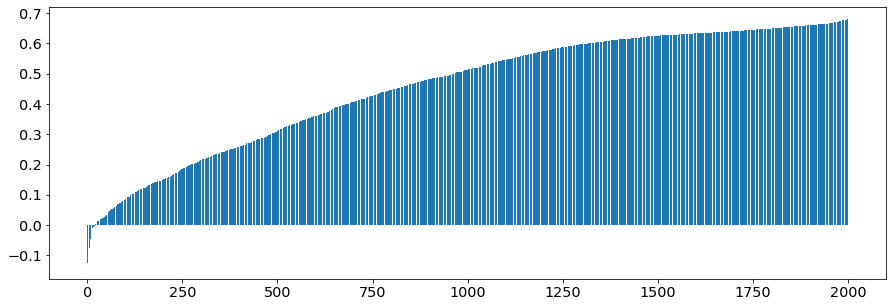

In [ ]:
labels = kmeans2.labels_
sil_sc = metrics.silhouette_score(X_sc, labels, metric='euclidean')
sil_samp = sorted(metrics.silhouette_samples(X_sc, labels))
print("SILHOUETTE SCORE: {:.4f}".format(sil_sc))
plt.bar(height = sil_samp, x=range(len(labels)));

#### Inercia

El algoritmo K-Means busca la elección de centroides que minimiza la **inercia** o **suma de cuadrados internas del cluster**:
$$
\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)
$$

Se define así la **inercia** como la suma de las distancias de cada punto a su centroide correspondiente

La inercia puede reconocerse como una medida de la coherencia interna de las agrupaciones. Pero tiene varios inconvenientes:

* La inercia supone que los conglomerados son convexos e isótropos, lo que no siempre es el caso. Responde mal a los conglomerados alargados o a las variedades con formas irregulares.

* La inercia no es una métrica normalizada: sólo sabemos que los valores más bajos son mejores y que cero es óptimo. Pero en espacios de muy alta dimensión, las distancias euclidianas tienden a inflarse (es un caso de la llamada "maldición de la dimensionalidad"). La ejecución de un algoritmo de reducción de la dimensionalidad, como el análisis de componentes principales (PCA), antes de la agrupación de k-means puede aliviar este problema y acelerar los cálculos.

In [ ]:
# Dado un estimador entrenado de KMeans como kmeans, es inmediato obtener la inercia
inertia = kmeans2.inertia_
print("INERTIA KMEANS: {:.4f}".format(inertia))

INERTIA KMEANS: 742.9528


## Uso de métricas internas para determinar K en K-Means

### Silhouette Score

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.4653576598093571
For n_clusters = 3 The average silhouette_score is : 0.5121845848634944
For n_clusters = 4 The average silhouette_score is : 0.5241706618280273
For n_clusters = 5 The average silhouette_score is : 0.45422863765462834
For n_clusters = 6 The average silhouette_score is : 0.4650898966003939


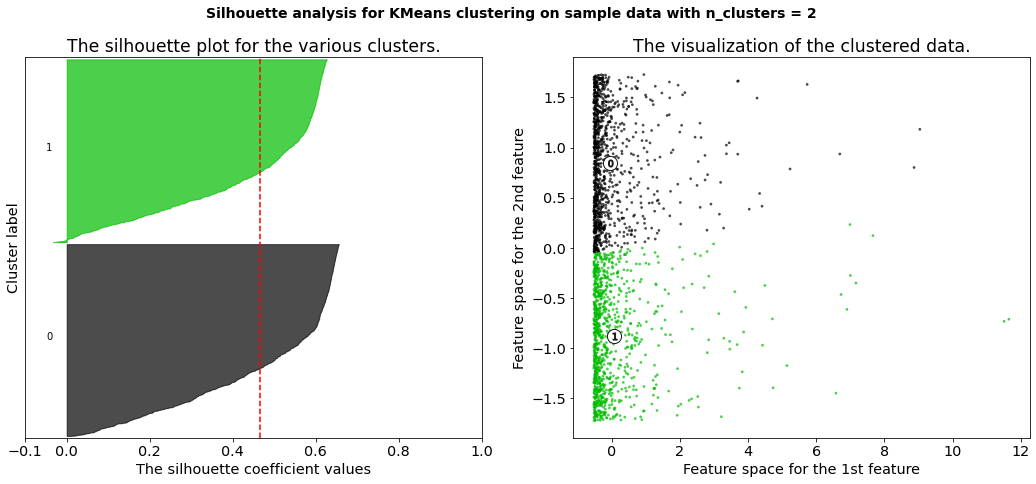

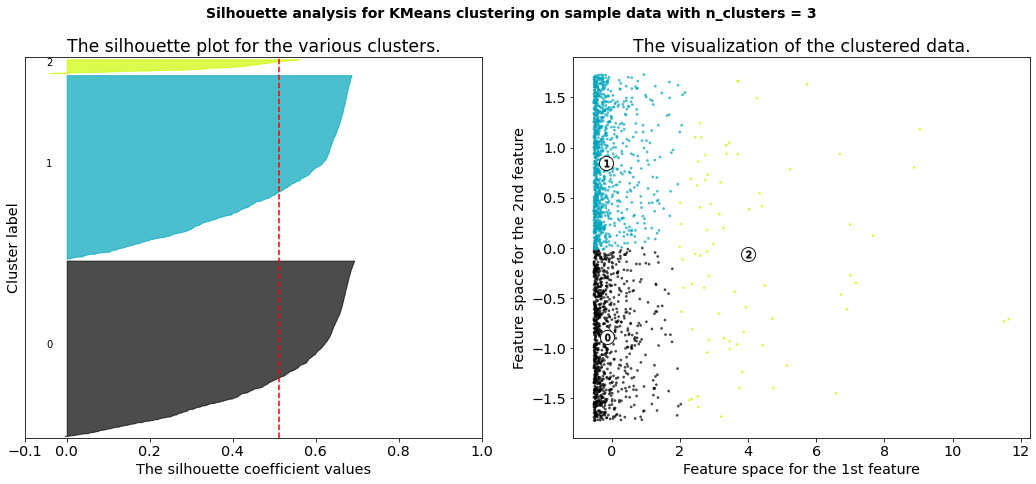

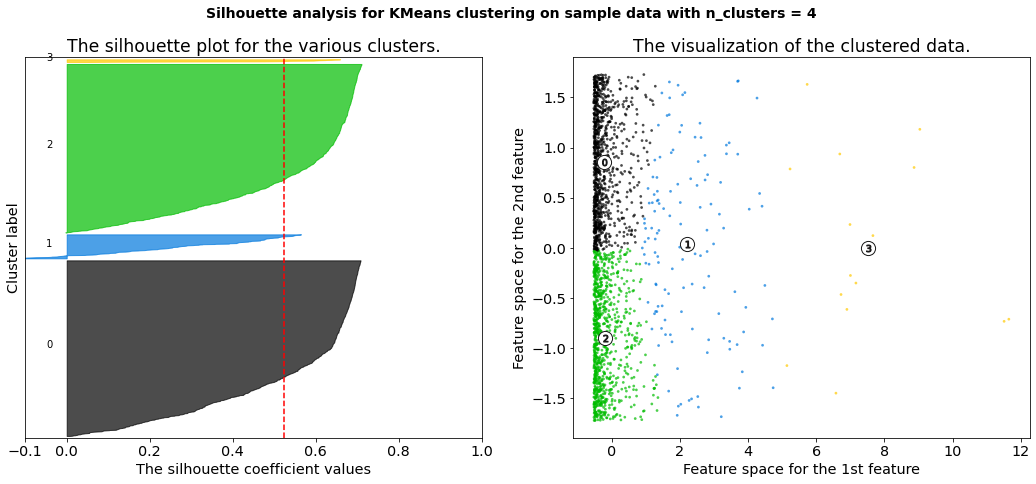

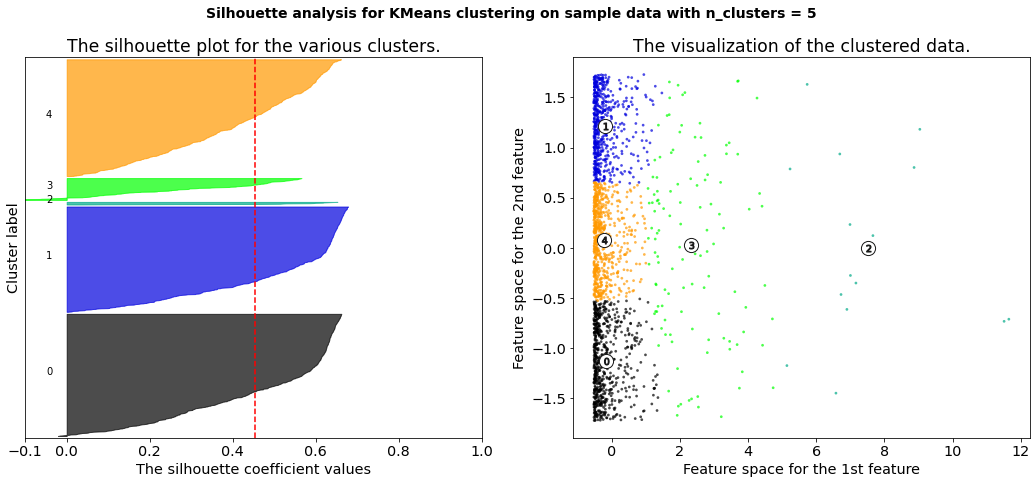

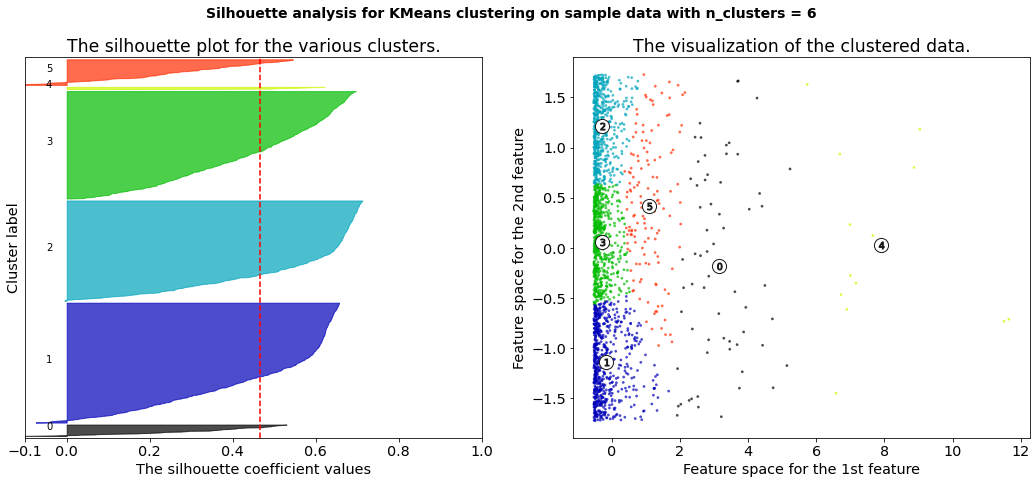

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


# X = df.copy()
# y = X['price_range']
# X.drop(columns='price_range', inplace=True)

# sc = StandardScaler()
# X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# kmeans_sil = KMeans(n_clusters=4, init="k-means++", n_init=4)
# kmeans_sil.fit(X_sc)
# X = X_sc
range_n_clusters = [2, 3, 4, 5, 6]
X = X_sc.copy()
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Método del Codo

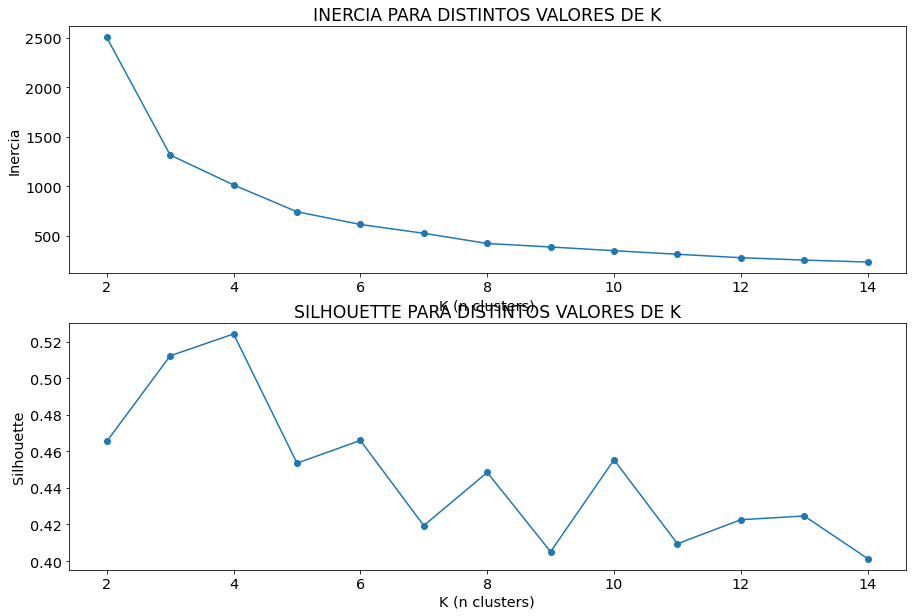

In [ ]:
# X = df.copy()
# y = X['price_range']
# X.drop(columns='price_range', inplace=True)

# sc = StandardScaler()
# X_sc = sc.fit_transform(X[['ram', 'battery_power']])

range_n_clusters = range(2, 15)

ls_inertia = []
ls_sil = []
for n in range_n_clusters:
    km_elb = KMeans(n_clusters=n, init="k-means++", n_init=4)
    km_elb.fit(X_sc)
    inertia_n = km_elb.inertia_
    sil_n = silhouette_score(X_sc, km_elb.labels_)
    ls_inertia.append(inertia_n)
    ls_sil.append(sil_n)
    
fig, ax = plt.subplots(2, 1, figsize=(15, 10))  
ax[0].plot(range_n_clusters, ls_inertia, 'o-')
ax[0].set(title='INERCIA PARA DISTINTOS VALORES DE K', 
       xlabel='K (n clusters)',
       ylabel='Inercia');

ax[1].plot(range_n_clusters, ls_sil, 'o-')
ax[1].set(title='SILHOUETTE PARA DISTINTOS VALORES DE K', 
       xlabel='K (n clusters)',
       ylabel='Silhouette');